# 2nd Notebook

## Overview

## Business Understanding

Introduction explains the real-world problem the project aims to solve

Introduction identifies stakeholders who could use the project and how they would use it


## Data Understanding

### Imports

In [3]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread 
import seaborn as sns
import chemparse
import pickle
import os

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, roc_auc_score, log_loss
from sklearn.utils import resample


%matplotlib inline
from imblearn.pipeline import Pipeline as ImPipeline

### Using Chemparse to augment Molecular Formula

This scripts take the 'dataset.tsv' file created by the 'Data Compiling' notebook, and augments it by breaking down the MolecularFormula into element-based features, where the feature is the number of atoms of that element in the formula.

This is done to essentially encode the molecular formula variable. I would like to include it as a variable, but first I need to encode the string based on the number of atoms for each atom in the string. These will be my numerical values. 

Element features are sorted by increasing atomic number.

WARNING: you need to install the chemparse python library to run this script (not to use the final dataset): https://pypi.org/project/chemparse/ , and also lxml

Output will be in 'datasetnew.tsv'

In [4]:
# reads html tables from the natural elements page
tables = pd.read_html('https://nutrients.ifas.ufl.edu/nutrient_pages/bsfpages/NaturalElements.htm')

In [5]:
# initializes list of elements
elements=[]

# fills elements from left side of table
for i in range(1,len(tables[1])):
    
    elements.append(tables[1][1][i])
    
# fills elements from right side of table
for i in range(1,len(tables[1])):
    
    # fix for the natural element table containing 'Ti' twice
    if(tables[1][5][i]=='Ti'):
        
        elements.append('TI')
        
    else:
        
        elements.append(tables[1][5][i])

    
# creates columns for the new dataframe
columns=['ChEBI',*elements,'FCharge']

In [6]:
# loads old dataset
df=pd.read_csv('../data/dataset.tsv',sep='\t')

# initializes list data structure, to pass to the dataframe constructor later
newdata=[]

In [7]:
# scan the old dataset, while creating a new 'row' for the new dataset, incrementally
for i in range(len(df)):
    
    row=[]
    
    row.append(df['ChEBI'][i])
    
    # if there is a molecular fomula
    if(not pd.isnull(df.MolecularFormula[i])):
        
        # parse it
        f=chemparse.parse_formula(df.MolecularFormula[i])
        
        # and for each element in our comprehensive list of elements
        for e in range(len(elements)):
            
            # put the number of atoms in the formula if present
            if(elements[e] in f):
                
                row.append(f[elements[e]])
                
            else:
                # or zero atoms if not present
                row.append(0.0)
                
        # then, look at the charge if present
        if('-' in f):
            
            row.append(-(f['-']))
            
        else:
            
            if('+' in f):
                
                row.append(f['+'])
                
            else:
                
                row.append(0.0)
                
        # row is ready, I can append it to the list
        newdata.append(row)
        #print(len(row))
                
    else:
        
        # append a row of None if no formula, with correct length
        for i in range(len(elements)+1):
            
            row.append(None)
            
        newdata.append(row)
        
        #print(len(row))

# here I create a new dataframe with the list above, and the columns previously defined
newdf = pd.DataFrame(newdata, columns =columns)

In [8]:
# merging old dataset with new data
finaldf=pd.merge(df,newdf,on='ChEBI',how='outer')


# pushing roletype and rolename at the end like in old dataframe

#Make a list of all of the columns in the df
cols = list(finaldf.columns.values) 
print(cols)

cols.pop(cols.index('RoleType'))
cols.pop(cols.index('RoleName')) 
print(cols)

#Create new dataframe with columns in the order you want
finaldf2 = finaldf[cols+['RoleType','RoleName']] 

#Make a list of all of the columns in the df
cols2 = list(finaldf2.columns.values) 

print(cols2)

for i in finaldf2.columns:
    print(i)
    
# write the final output
finaldf2.to_csv('datasetnew.tsv',sep='\t')

['Unnamed: 0', 'ChEBI', 'MolecularFormula', 'MolecularWeight', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount', 'RoleType', 'RoleName', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'A', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'TI', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'FCharge']
['Unnamed: 0', 'ChEBI', 'MolecularFormula', 'MolecularWeight', 'XLogP', 'ExactMass', 'Monoisotopic

### Reading in Data

In [9]:
df= pd.read_csv('../data/datasetnew.tsv', sep='\t')

# dropping extra variables which resulted from chemparse
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df

,ChEBI,MolecularFormula,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,...,Rn,Fr,Ra,Ac,Th,Pa,U,FCharge,RoleType,RoleName
0,19032,C2H4BrCl,143.410,1.6,141.918490,141.918490,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,mutagen
1,21182,C23H30Cl5N3O,541.800,NaN,541.080201,539.083151,37.4,494.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,intercalator
2,21183,C21H27Cl4N3O,479.300,NaN,479.087873,477.090823,37.4,442.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,intercalator
3,28925,C5H11Cl2N,156.050,0.9,155.026855,155.026855,3.2,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,alkylating agent
4,40910,N3-,42.021,1.5,42.009222,42.009222,3.0,15.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,biological role,mitochondrial respiratory-chain inhibitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,90890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,bacterial metabolite
10484,131528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,bacterial metabolite
10485,90785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,bacterial metabolite
10486,77774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,phosphodiesterase IV inhibitor


In [10]:
# Checking for duplicates of the formula. Since Molecular Formula is not a unique ID, this is expected
df.MolecularFormula.duplicated().sum()

3817

In [11]:
# dropping Molecular formula and FCharge, as both are accounted for in chemparse. 
# we can also drop Molecular Weight, since exact mass and monoisopotic mass are essentially accounting for this.
df.drop(['MolecularFormula', 'FCharge', 'MolecularWeight'], axis=1, inplace=True)

## Data Preparation

### Exploring the Data

In [12]:
# begining preliminary data exploration, basic steps.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10488 entries, 0 to 10487
Columns: 110 entries, ChEBI to RoleName
dtypes: float64(107), int64(1), object(2)
memory usage: 8.8+ MB


In [13]:
df.dtypes.value_counts()

float64    107
object       2
int64        1
dtype: int64

In [14]:
desc_df = df.describe()
pd.set_option('display.max_columns', 100000)

desc_df

,ChEBI,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,A,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr,Rb,Sr,Y,Zr,Nb,Mo,Tc,Ru,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,TI,Pb,Bi,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U
count,10488.000000,9461.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10454.000000,10137.000000,10137.000000,10454.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.0,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.0,10137.000000,10137.000000,10137.0,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.000000,10137.0,10137.0,10137.000000,10137.000000,10137.000000,10137.0,10137.0,10137.000000,10137.000000,10137.000000,10137.0,10137.000000,10137.0,10137.000000,10137.0,10137.000000,10137.000000,10137.000000,10137.0,10137.000000,10137.000000,10137.000000,10137.000000,10137.0,10137.0,10137.000000,10137.000000,10137.000000,10137.0,10137.0,10137.0,10137.0,10137.0,10137.000000,10137.0,10137.0,10137.0,10137.0,10137.0,10137.000000,10137.0,10137.0,10137.0,10137.000000,10137.0,10137.0,10137.0,10137.000000,10137.000000,10137.000000,10137.0,10137.000000,10137.000000,10137.0,10137.0,10137.0,10137.0,10137.0,10137.0,10137.0,10137.0,10137.0
mean,74864.215103,2.137639,415.891932,415.872413,124.558814,612.235573,-0.051495,3.510111,7.124494,9.151031,28.678209,0.002664,3.867324,3.754562,0.233698,0.490626,30.016178,0.000099,0.001677,0.000197,0.003749,20.401204,1.427247,6.272862,0.096676,0.0,0.019927,0.003453,0.000296,0.002664,0.138700,0.159909,0.091940,0.0,0.003946,0.001282,0.0,0.000099,0.000197,0.000691,0.000986,0.004538,0.001184,0.000789,0.000691,0.001184,0.0,0.0,0.002269,0.002269,0.014304,0.0,0.0,0.000099,0.000099,0.000099,0.0,0.000395,0.0,0.000592,0.0,0.000296,0.000197,0.000099,0.0,0.000197,0.000493,0.000099,0.017165,0.0,0.0,0.000395,0.000099,0.000099,0.0,0.0,0.0,0.0,0.0,0.000099,0.0,0.0,0.0,0.0,0.0,0.000099,0.0,0.0,0.0,0.000296,0.0,0.0,0.0,0.001184,0.000197,0.000395,0.0,0.000296,0.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,50620.763215,5.906363,298.360593,298.334518,123.898712,582.065052,0.522682,4.428321,7.115776,11.744643,20.542135,0.084823,6.489437,6.539309,0.653550,1.380273,26.218768,0.009932,0.062007,0.014046,0.085362,14.935494,2.255761,6.909047,0.917431,0.0,0.207870,0.063506,0.017201,0.095750,0.517548,0.536529,0.461876,0.0,0.111424,0.035790,0.0,0.009932,0.014046,0.029790,0.031394,0.135388,0.034387,0.037156,0.029790,0.034387,0.0,0.0,0.058719,0.047581,0.193350,0.0,0.0,0.009932,0.009932,0.009932,0.0,0.019861,0.0,0.024323,0.0,0.017201,0.014046,0.009932,0.0,0.014046,0.029794,0.009932,0.232309,0.0,0.0,0.019861,0.009932,0.009932,0.0,0.0,0.0,0.0,0.0,0.009932,0.0,0.0,0.0,0.0,0.0,0.009932,0.0,0.0,0.0,0.017201,0.0,0.0,0.0,0.048646,0.014046,0.019861,0.0,0.017201,0.009932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,25.000000,-24.300000,2.015650,2.015650,0.000000,0.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,

In [15]:
# checking for nulls and duplicates
df.isnull().sum()

ChEBI                  0
XLogP               1027
ExactMass            351
MonoisotopicMass     351
TPSA                 351
                    ... 
Th                   351
Pa                   351
U                    351
RoleType               0
RoleName               0
Length: 110, dtype: int64

In [16]:
df.index.duplicated().sum()

0

In [17]:
df.duplicated().sum()

0

In [18]:
df.shape

(10488, 110)

### Cleaning the Data

In [19]:
# visualizing the percentage of nulls from the entire df, specifically associated with each column

cols = list(df.columns)

def null_percentage(df, cols):
    
    list_of_percentages = []
    
    #iterating through the columns
    for i in cols:
        
        #calculating the percentage of nulls for each column
        percent = ((df[i].isna().sum())/(len(df))) * 100
    
        list_of_percentages.append(percent)
    
    #zipping together the two lists 
    zip_list = zip(cols, list_of_percentages)   

    return zip_list

In [20]:
list(null_percentage(df, cols))

[('ChEBI', 0.0),
 ('XLogP', 9.79214340198322),
 ('ExactMass', 3.3466819221967965),
 ('MonoisotopicMass', 3.3466819221967965),
 ('TPSA', 3.3466819221967965),
 ('Complexity', 3.3466819221967965),
 ('Charge', 3.3466819221967965),
 ('HBondDonorCount', 3.3466819221967965),
 ('HBondAcceptorCount', 3.3466819221967965),
 ('RotatableBondCount', 3.3466819221967965),
 ('HeavyAtomCount', 3.3466819221967965),
 ('IsotopeAtomCount', 3.3466819221967965),
 ('AtomStereoCount', 0.32418001525553014),
 ('DefinedAtomStereoCount', 3.3466819221967965),
 ('UndefinedAtomStereoCount', 3.3466819221967965),
 ('BondStereoCount', 0.32418001525553014),
 ('H', 3.3466819221967965),
 ('He', 3.3466819221967965),
 ('Li', 3.3466819221967965),
 ('Be', 3.3466819221967965),
 ('B', 3.3466819221967965),
 ('C', 3.3466819221967965),
 ('N', 3.3466819221967965),
 ('O', 3.3466819221967965),
 ('F', 3.3466819221967965),
 ('Ne', 3.3466819221967965),
 ('Na', 3.3466819221967965),
 ('Mg', 3.3466819221967965),
 ('Al', 3.3466819221967965),


In [21]:
# dropping nulls if they make up less than 5% of the data. 

null_list = list(null_percentage(df, cols))

for x in null_list:
    
    # if the nulls make up less than 5%, drop
    if x[1].astype(float) < 5:

        df.dropna(axis=0,subset=[x[0]], inplace=True)  

In [22]:
# checking what's left 
null_list = list(null_percentage(df, cols))
null_list

[('ChEBI', 0.0),
 ('XLogP', 6.668639636973464),
 ('ExactMass', 0.0),
 ('MonoisotopicMass', 0.0),
 ('TPSA', 0.0),
 ('Complexity', 0.0),
 ('Charge', 0.0),
 ('HBondDonorCount', 0.0),
 ('HBondAcceptorCount', 0.0),
 ('RotatableBondCount', 0.0),
 ('HeavyAtomCount', 0.0),
 ('IsotopeAtomCount', 0.0),
 ('AtomStereoCount', 0.0),
 ('DefinedAtomStereoCount', 0.0),
 ('UndefinedAtomStereoCount', 0.0),
 ('BondStereoCount', 0.0),
 ('H', 0.0),
 ('He', 0.0),
 ('Li', 0.0),
 ('Be', 0.0),
 ('B', 0.0),
 ('C', 0.0),
 ('N', 0.0),
 ('O', 0.0),
 ('F', 0.0),
 ('Ne', 0.0),
 ('Na', 0.0),
 ('Mg', 0.0),
 ('Al', 0.0),
 ('Si', 0.0),
 ('P', 0.0),
 ('S', 0.0),
 ('Cl', 0.0),
 ('A', 0.0),
 ('K', 0.0),
 ('Ca', 0.0),
 ('Sc', 0.0),
 ('Ti', 0.0),
 ('V', 0.0),
 ('Cr', 0.0),
 ('Mn', 0.0),
 ('Fe', 0.0),
 ('Co', 0.0),
 ('Ni', 0.0),
 ('Cu', 0.0),
 ('Zn', 0.0),
 ('Ga', 0.0),
 ('Ge', 0.0),
 ('As', 0.0),
 ('Se', 0.0),
 ('Br', 0.0),
 ('Kr', 0.0),
 ('Rb', 0.0),
 ('Sr', 0.0),
 ('Y', 0.0),
 ('Zr', 0.0),
 ('Nb', 0.0),
 ('Mo', 0.0),
 ('Tc'

In [23]:
clean_df = df
clean_df.shape

(10137, 110)

### Feature Engineering

XLogP still remains. I don't feel comfortable dropping these nulls.

In [24]:
# A null XLogP is important information, as it means a reaction did not occur to calculate the XLogP in the first place.
# This tells us information about the nature of the compound. A null here is different from a 0 value. 
clean_df.XLogP.isnull().value_counts()

False    9461
True      676
Name: XLogP, dtype: int64

In [25]:
#checking to see how this relates to each class
clean_df[pd.isnull(clean_df.XLogP)].RoleType.value_counts()

application        358
biological role    266
chemical role       52
Name: RoleType, dtype: int64

Because domain knowledge of XLogP is that values all have a significance, we can't assign 0 as a neutral value. 

Instead, we will assign most frequent as neutral value.

In [26]:
clean_df.XLogP.value_counts().sort_values()

# because the number of nulls associataed with XLogP is 676, which is 5 times the amount of the most frequent value,
# we can't simply add it, but rather we need to bin. 
# Otherwise, the most frequent class will be a lot more frequent. 
# 1.5 is most frequent, and the top 5 most frequent values are close enough to one another. 
# I can add values to the most frequent class without the data being affected more. 

-24.3      1
 22.3      1
 24.8      1
 23.0      1
 26.4      1
        ... 
 2.4     115
 2.1     115
 2.5     119
 2.0     121
 1.5     129
Name: XLogP, Length: 418, dtype: int64

In [27]:
# using pd.qcut to create bins
ser, bins= pd.qcut(clean_df.XLogP, retbins=True, q=5)

In [28]:
bins

array([-24.3,  -1.8,   1. ,   2.8,   5.2,  40.4])

In [29]:
# checking to see how it was binned for each interval of value, whether it's balanced or not.
ser.value_counts()

(-24.301000000000002, -1.8]    1926
(-1.8, 1.0]                    1907
(5.2, 40.4]                    1890
(2.8, 5.2]                     1887
(1.0, 2.8]                     1851
Name: XLogP, dtype: int64

In [30]:
# using pd.cut to assign values to bins
clean_df['XLogP_qcut'] = pd.cut(clean_df.XLogP, bins=bins, labels=False)
clean_df.drop('XLogP', axis=1, inplace=True)

# checking to see how the binning looks
clean_df.XLogP_qcut.value_counts()

0.0    1925
1.0    1907
4.0    1890
3.0    1887
2.0    1851
Name: XLogP_qcut, dtype: int64

In [31]:
#Make a list of all of the columns in the df
cols = list(clean_df.columns.values) 

cols.pop(cols.index('RoleType')) 
cols.pop(cols.index('RoleName')) 

#Create new dataframe with columns in the order we want
clean_df = clean_df[cols+['RoleType','RoleName']]

In [32]:
# handling a warning that we can ignore
pd.options.mode.chained_assignment = None

# adressing remaining null values
clean_df.XLogP_qcut.fillna(value=2, inplace=True)
clean_df.XLogP_qcut.value_counts()

#this way, there is not as much of class imbalance for XLogP values

2.0    2528
0.0    1925
1.0    1907
4.0    1890
3.0    1887
Name: XLogP_qcut, dtype: int64

# Role Type Classification

### The first part of this notebook creates models which can classify Role Type. 

###### The second part of this notebook creates models which can classify Role Name. We will get to those below.

## Role Type Data

In [33]:
# cheking for class imbalance. We can see a clear class imbalance.
clean_df.RoleType.value_counts()

biological role    8642
application        1329
chemical role       166
Name: RoleType, dtype: int64

In [34]:
# grouping by the role type
bio_rt_df = clean_df[clean_df['RoleType'] == 'biological role']
chem_rt_df = clean_df[clean_df['RoleType'] == 'chemical role']
app_rt_df = clean_df[clean_df['RoleType'] == 'application']

#upsample the minority class and downsample majority
chem_rt_df = resample(chem_rt_df, random_state=42, n_samples=1500, replace=True)
bio_rt_df = resample(bio_rt_df, random_state=42, n_samples=2500, replace=False)

balanced_rt_df = pd.concat([bio_rt_df, chem_rt_df, app_rt_df])
balanced_rt_df.RoleType.value_counts()

biological role    2500
chemical role      1500
application        1329
Name: RoleType, dtype: int64

In [35]:
balanced_rt_df

,ChEBI,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,A,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr,Rb,Sr,Y,Zr,Nb,Mo,Tc,Ru,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,TI,Pb,Bi,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,XLogP_qcut,RoleType,RoleName
9870,73096,904.498928,904.498928,148.0,2410.0,0.0,1.0,10.0,22.0,66.0,0.0,4.0,4.0,0.0,2.0,68.0,0.0,0.0,0.0,0.0,55.0,4.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,biological role,cofactor
5696,77996,563.527745,563.527745,69.6,574.0,0.0,3.0,3.0,31.0,40.0,0.0,2.0,2.0,0.0,2.0,69.0,0.0,0.0,0.0,0.0,36.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,biological role,mouse metabolite
814,545687,228.136159,228.136159,74.6,233.0,0.0,2.0,4.0,10.0,16.0,0.0,0.0,0.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,12.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,biological role,plant hormone
5085,18040,162.100442,162.100442,110.0,129.0,0.0,4.0,5.0,5.0,11.0,0.0,2.0,2.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,6.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,human metabolite
923,59415,540.180268,540.180268,271.0,843.0,0.0,9.0,15.0,10.0,37.0,0.0,12.0,12.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,20.0,2.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,epitope
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10439,189588,166.062994,166.062994,39.4,175.0,0.0,0.0,3.0,4.0,12.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,9.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,flavouring agent
10440,82038,347.111735,347.111735,112.0,463.0,0.0,1.0,9.0,7.0,25.0,0.0,0.0,0.0,0.0,1.0,17.0,0.0,0.0,0.0

### Creating Helper Functions

##### This class is created to help with cross validation, plotting, and visualization down the line

In [36]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 5)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        
        print(cv_summary)
    

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax)

        return ax

# From David Elliot's lecture on classification workflow

### Role Type Train-Test Split

Dropping ChEBI since it's a unique ID. We didn't drop it before for ease of navigating the df. 

In [35]:
# ChEBI is no longer needed for training. 
# This train-test split is specific for the Role Type, so we can also drop Role Name

X = balanced_rt_df.drop(['RoleType', 'RoleName', 'ChEBI'], axis=1)
y = balanced_rt_df['RoleType']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Role Type Modelling

Creating a pipeline for ease of flow and updating models

Creating pipelines which we will use to scale, and potentially encode and impute the dataframe. 

Scaling numerical values.

We are able to access numerical data with the 'grab' function below. 

The function transformer allows us to include the functions in the pipelines. 

A pipeline is created for numerical values. 

It is then included in the column transformer pipeline to prevent data leakeage. 

We will be using X_train data, but this will also account for the changes which need to be made to testing data.

In [36]:
# we grab the numeric values and scale them as part of the pipeline


# this function grabs numerical values
def grab_numeric_rt(df):
    return df.select_dtypes(include=['float', 'int'])

#we use a FunctionTransformer for the pipeline
GrabNumeric_rt = FunctionTransformer(grab_numeric_rt)

subpipe_num = Pipeline(steps=[('get_num', GrabNumeric_rt),
                              ('ss', StandardScaler())])

# need a ColumnTransformer to actually make the changes to the columns
ct = ColumnTransformer(transformers = [('subpipe_num', subpipe_num, X_train.columns),])

### Baseline Model

In [37]:
# creating a baseline model to compare performance

dummy_model = DummyClassifier(strategy='most_frequent')

dummy_model.fit(X_train, y_train)

dummy_model_res = ModelWithCV(
    model=dummy_model,
    model_name='dummy_model',
    X=X_train,
    y=y_train)

CV Results for `dummy_model` model:
            0.46897 ± 0.00050 accuracy
        
 Train: 0.46896896896896895


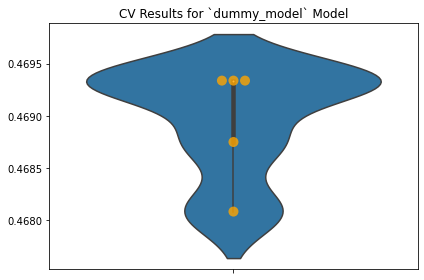

In [38]:
# plotting and visualization using previously created class

fig, ax = plt.subplots()

ax = dummy_model_res.plot_cv(ax)
plt.tight_layout();

dummy_model_res.print_cv_summary()

dummy_train_score = dummy_model.score(X_train, y_train)
print(f' Train: {dummy_train_score}')

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


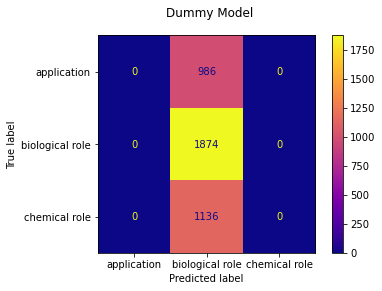

In [39]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

Looks like 0.468 is the accuracy score to beat. This is the mean of the 5 accuracy scores of CV for this model.
The dummy model picked biological role each time for every entry. Because there are more biological roles, it makese sense that this dummy classifier didn't perform as horribly as expected. 

We want our subsequent models to have higher accuracy.

### Logistic Regression

I decided to start with logistic regression, as I'm curious as to how a simple, distance based model will perform.

In [40]:
# feeding logistic regression through my pipeline 
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

# fitting on split data
logreg_model_pipe.fit(X_train, y_train)

# and creating visualizations
log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X_train, 
                       y=y_train)

CV Results for `log_pipe` model:
            0.66442 ± 0.00984 accuracy
        
 Train: 0.6804304304304304


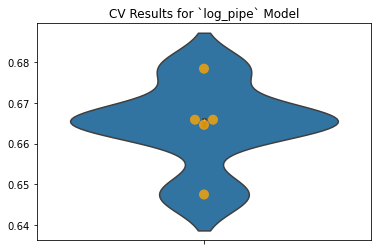

In [41]:
# plotting and visualizing 
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

lr_train_score = logreg_model_pipe.score(X_train, y_train)
print(f' Train: {lr_train_score}')

These results are much better than the baseline model, right out the gate. Additionally, we can see that the train score is similar to the cv score, so the model is not overfit. The cv acts like a 'pseudo' test within the train data to isolate the actual testing data, thus preventing data leakage. 

Since this model is not overfit, but the score is not as high as I'd like, I can add more complexity and more features to get a better score. However, the risk of overfitting still stands if this is done. If I want to try to increase score without adding more complexity, I can reduce regularization. This doesn't increase complexity by adding more features, but rather, it reduces the penalty. 

If I reduce regularization strength with a smaller C value, and the cv results happen to be worse than train scores, the model is overfit. I might not be able to pull more information out because I don't want to overfit. We will address this later with a GridSearch to maximize our hyperparameters. For now, this is a good starting point.

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


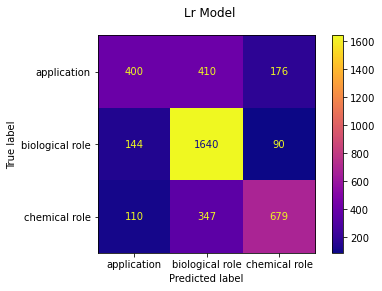

In [42]:
fig, ax = plt.subplots()

fig.suptitle("Lr Model")

plot_confusion_matrix(logreg_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

### Decision Trees

I'm also curious how tree based models will perform, so I'm starting with the simpler version which only randomizes the sampling of data.

Decision trees are inherently overfit. But I want to explore other options for models before deciding on logistic regression.

In [43]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X_train, y_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `dt_pipe` model:
            0.80105 ± 0.00657 accuracy
        
 Train: 0.9974974974974975


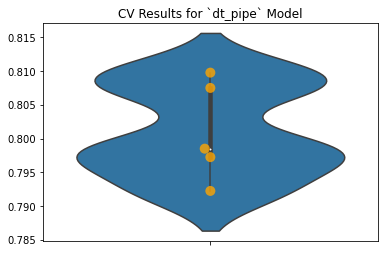

In [44]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

dt_train_score = dt_model_pipe.score(X_train, y_train)
print(f' Train: {dt_train_score}')

Much higher accuracy, however very overfit. This is expected of tree based classifiers.

This model performs better than logistic regression because a tree based algorithm will handle this type of data better, with more than 2 possible classes. This is not a binary problem.

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


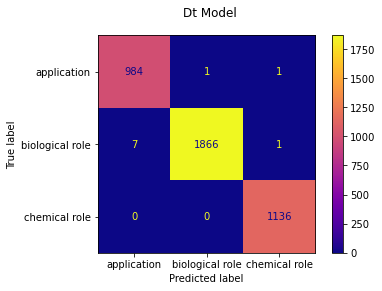

In [45]:
fig, ax = plt.subplots()

fig.suptitle("Dt Model")

plot_confusion_matrix(dt_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

### Random Forest

Let's see how a more complex tree based estimator performs.

I'm going to use an estimator which uses decision trees as its predetermined estimator, while at the same time adding two levels of randomization. 

Random forest classifier uses bagging (first level of randomization) and feature randomness (second level of randomization) when building each individual tree to try to create an uncorrelated forest of trees whose prediction by all of the trees is more accurate than that of any individual tree.

In [46]:
# rfc_model_pipe = Pipeline(steps=[
#                 ('ct', ct), 
#                 ('rfc', RandomForestClassifier(n_jobs=-1, random_state=42))])

# rfc_model_pipe.fit(X_train, y_train)

rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10000, max_depth=13, random_state=42)
rfc.fit(X_train, y_train)

forest_res = ModelWithCV(model=rfc, 
                          model_name='rfc',
                          X=X_train, 
                          y=y_train)

The reason I didn't feed this through my pipeline is because once I finished modeling, I discovered random forest was in fact the best classifier. 

When inputing it into streamlit, there was a discrepancy with the pipeline. The only way it works is if pipeline is not used. I decided to forgo using a pipeline for my random forest classifier because it doesn't need to be scaled (standard scaler is the only thing in my pipeline), and because streamlit will only work if there is no pipeline.

This is why the original pipeline is commented out, and I'm using a normal instantiation method instead.

CV Results for `rfc` model:
            0.84560 ± 0.00908 accuracy
        
 Train: 0.9356856856856857


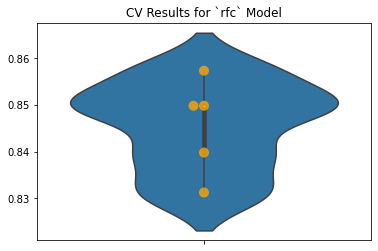

In [47]:
fig, ax = plt.subplots()

forest_res.plot_cv(ax=ax)

forest_res.print_cv_summary()

rf_train_score = rfc.score(X_train, y_train)
print(f' Train: {rf_train_score}')

This is overfit, but performs the best. This is expected with a tree based algorithm. I will adress overfitting later on in my grid search. As of now, I performed all the feature engineering I could to reduce overfitting. 
The data I'm using is not as robust as I would like, which is most likely the reason for an overfit model. 

It's worth noting that random forests performed better than decision trees, so for now this is at the top of my list of estimators. This is because of the added layer of complexity.

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


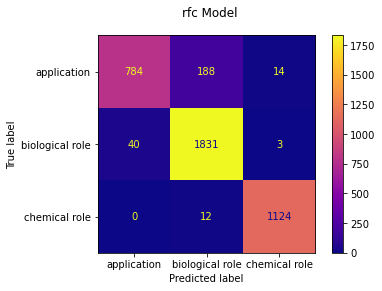

In [48]:
fig, ax = plt.subplots()

fig.suptitle("rfc Model")

plot_confusion_matrix(rfc, X_train, y_train, ax=ax, cmap="plasma");

### KNeighborsClassifier

Since I reached the maximum accuracy score using estimators that use decition trees, I will now try to pivot directions, while at the same time keeping the random forest classifier in mind as the best performing model so far. This is an iterative approach, so I would like to try to approach this from yet another angle. 

Logistic regression was also decent, so I'm going to expand on that, just like how I expanded on the first decision trees model. Kneighbors classifier is another distance based algorithm similar to logistic regression. The difference, however, is that Lr looks at distance between true values and predictions, whereas KNN uses the distance in the final .predict step under the hood. 

They use distance metrics a bit differently, but they are still both distance metrics at the end of the day. Let's see how another distance based estimator does.

I will be comparing this one more closely to logistic regression, however I am still interested to see how it fairs compared to the tree based models as well.

In [49]:
knn_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('knn', KNeighborsClassifier())])

knn_model_pipe.fit(X_train, y_train)

knn_pipe = ModelWithCV(model=knn_model_pipe,
                         model_name='knn_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `knn_pipe` model:
            0.79229 ± 0.00509 accuracy
        
 Train: 0.8633633633633634


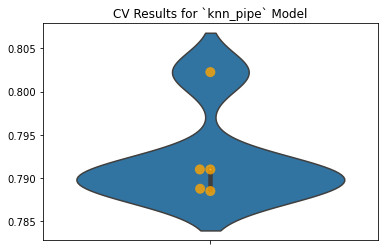

In [50]:
fig, ax = plt.subplots()

knn_pipe.plot_cv(ax=ax);

knn_pipe.print_cv_summary()

knn_train_score = knn_model_pipe.score(X_train, y_train)
print(f' Train: {knn_train_score}')

Not too overfit, yet accuracy not as high as random forest or decision trees. 

Accuracy is higher than logistic regression, which is expected, since a sigmoid curve won't necessaritly do the trick for this number of potential classes. However, Random Forest Classifier is still my model of choice for now.

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


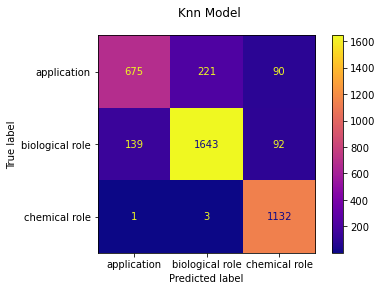

In [51]:
fig, ax = plt.subplots()

fig.suptitle("Knn Model")

plot_confusion_matrix(knn_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

### GradientBoostingClassifier

Finally, I'm interested in how a gradient boosting classifier performs compared to random forest (which is best performer up until this point). 

I'm curious to see how another ensemble classifier performs.

Gradient boosting classifier combines many weaker learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting. I would like to see if boosting will result in better scores than random forest, since both use decision trees. Gradient boosting classifier minimizes a loss function by iteratively choosing a function that points towards the negative gradient.

In [52]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X_train, y_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `boost_pipe` model:
            0.78179 ± 0.01372 accuracy
        
 Train: 0.8270770770770771


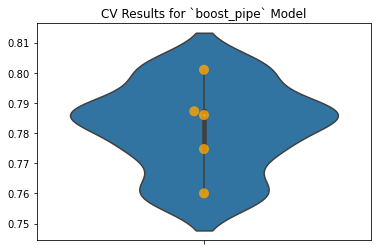

In [53]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

gbc_train_score = gbc_model_pipe.score(X_train, y_train)
print(f' Train: {gbc_train_score}')

Definitely less overfit, but accuracy is not as high as random forest. This is the trade-off I'm trying to address with hyperparameter tuning.

A reason for this might be that random forests are better equiped at handling this type of data, in the way that it has been presented. This might change if the dataset were fuller.

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


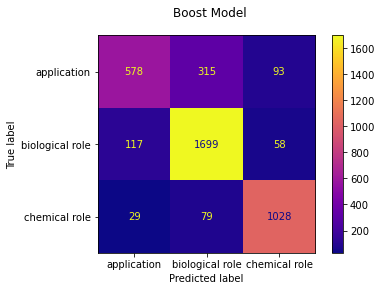

In [54]:
fig, ax = plt.subplots()

fig.suptitle("Boost Model")

plot_confusion_matrix(gbc_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

## Hyperparameter Tuning

### Grid Search

Performing a grid search cv on my 2 best models: random forest and gradient boosting classifiers.
I'm interested in the loss metric of the model as much as I am in the accuracy, to better assess how my model is performing on any given split. 

I have also already tweaked certain parameters to account for overfitting, so I will be running other parameters in my grid search.

In [55]:
# setting up paremeters I would like to include in the grid search
params_rfc = {
    'max_features': ['sqrt', 'log2', None],
    'criterion' : ['gini', 'entropy']}

# because I want to account for randomness, I am doing a grid search CV with 5 splits.
gs_rfc = GridSearchCV(rfc, 
                      params_rfc, 
                      scoring=['accuracy','neg_log_loss'],
                      refit='accuracy',                  
                      cv=5, 
                      verbose=3)

# fitting the gridsearchCV on split data
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.831) neg_log_loss: (test=-0.457) total time=   8.5s
[CV 2/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.850) neg_log_loss: (test=-0.452) total time=   8.4s
[CV 3/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.840) neg_log_loss: (test=-0.449) total time=   7.9s
[CV 4/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.850) neg_log_loss: (test=-0.459) total time=   7.8s
[CV 5/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.857) neg_log_loss: (test=-0.450) total time=   7.9s
[CV 1/5] END criterion=gini, max_features=log2; accuracy: (test=0.812) neg_log_loss: (test=-0.515) total time=   7.3s
[CV 2/5] END criterion=gini, max_features=log2; accuracy: (test=0.842) neg_log_loss: (test=-0.508) total time=   7.3s
[CV 3/5] END criterion=gini, max_features=log2; accuracy: (test=0.834) neg_log_loss: (test=-0.511) total time=   7

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=13, n_estimators=10000,
                                              n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2', None]},
             refit='accuracy', scoring=['accuracy', 'neg_log_loss'], verbose=3)

In [56]:
print(gs_rfc.best_params_)
print(gs_rfc.best_score_)
pd.DataFrame(gs_rfc.cv_results_)

{'criterion': 'entropy', 'max_features': None}
0.8498526282853567


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,5.192854,0.282641,2.917394,0.020490,gini,sqrt,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.83125,0.849812,0.839800,0.849812,0.857322,0.845599,0.009082,3,-0.456734,-0.451617,-0.449197,-0.459067,-0.450323,-0.453387,0.003835,4
1,4.399021,0.035589,2.896566,0.006794,gini,log2,"{'criterion': 'gini', 'max_features': 'log2'}",0.81250,0.842303,0.833542,0.833542,0.844806,0.833339,0.011368,5,-0.514779,-0.508013,-0.510940,-0.516884,-0.509704,-0.512064,0.003282,6
2,17.182365,0.358701,3.003515,0.023455,gini,None,"{'criterion': 'gini', 'max_features': None}",0.82625,0.828536,0.838548,0.824781,0.844806,0.832584,0.007776,6,-0.428379,-0.403736,-0.392481,-0.415368,-0.399371,-0.407867,0.012673,2
3,5.684885,0.206231,2.914284,0.031712,entropy,sqrt,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.83125,0.858573,0.843554,0.847309,0.856070,0.847351,0.009753,2,-0.445979,-0.444179,-0.443992,-0.454167,-0.440908,-0.445845,0.004469,3
4,5.202216,0.221188,2.935603,0.020975,entropy,log2,"{'criterion': 'entropy', 'max_features': 'log2'}",0.81875,0.846058,0.833542,0.837297,0.851064,0.837342,0.011175,4,-0.509036,-0.503943,-0.508507,-0.515514,-0.506452,-0.508690,0.003854,5
5,22.510904,0.539378,2.857884,0.133188,entropy,None,"{'criterion': 'entropy', 'max_features': None}",0.83875,0.851064,0.857322,0.839800,0.862328,0.849853,0.009351,1,-0.395870,-0.378017,-0.360001,-0.387217,-0.362125,-0.376646,0.013936,1


The sixth split has the highest rank for both accuracy and loss. This is what I'm going with.

Performing grid search on gradient boosting classifier next.

GBC was not as overfit as random forests, so I am actually interested to see how n_estimators and max_depth perform in different splits.

In [57]:
params_gbc = {
    'gbc__n_estimators' : [90,100,110],
    'gbc__max_depth' : [10,14,16]}

gs_gbc = GridSearchCV(gbc_model_pipe, 
                      params_gbc, 
                      scoring=['accuracy','neg_log_loss'],
                      refit='accuracy',  
                      n_jobs=-1, 
                      cv=5, 
                      verbose=3)

gs_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric_rt at 0x7fcdad089040>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge',
       'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount',
       'HeavyAtomCount', 'IsotopeAtomCount',
       ...
       'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'XLogP_qcut'],
      dtype='object', length=107))])),
                                       ('gbc',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gbc__max_depth': [10, 14, 16],
                         'gbc__n_estimators': [90, 100, 110]},
             refit='accuracy', scoring=['accuracy', 'neg_log_loss'], verbose=3)

In [58]:
print(gs_gbc.best_params_)
print(gs_gbc.best_score_)
pd.DataFrame(gs_gbc.cv_results_)

{'gbc__max_depth': 14, 'gbc__n_estimators': 100}
0.8646145181476846


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbc__max_depth,param_gbc__n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,6.676254,0.046519,0.030904,0.002635,10,90,"{'gbc__max_depth': 10, 'gbc__n_estimators': 90}",0.86000,0.852315,0.864831,0.843554,0.871089,0.858358,0.009616,5,-0.411621,-0.398581,-0.378587,-0.388582,-0.343070,-0.384088,0.023242,1
1,7.413191,0.027807,0.032892,0.001991,10,100,"{'gbc__max_depth': 10, 'gbc__n_estimators': 100}",0.85375,0.854819,0.867334,0.848561,0.872340,0.859361,0.008953,4,-0.423327,-0.415801,-0.385722,-0.393429,-0.351740,-0.394004,0.025259,2
2,8.073437,0.071107,0.037851,0.003192,10,110,"{'gbc__max_depth': 10, 'gbc__n_estimators': 110}",0.85875,0.851064,0.861076,0.846058,0.871089,0.857607,0.008617,6,-0.435169,-0.431991,-0.394788,-0.402415,-0.359268,-0.404726,0.027715,3
3,11.094528,0.121592,0.046837,0.002622,14,90,"{'gbc__max_depth': 14, 'gbc__n_estimators': 90}",0.86125,0.851064,0.869837,0.853567,0.872340,0.861612,0.008472,3,-0.608201,-0.585802,-0.564604,-0.569872,-0.479354,-0.561567,0.043816,4
4,12.140031,0.145068,0.050749,0.003386,14,100,"{'gbc__max_depth': 14, 'gbc__n_estimators': 100}",0.86500,0.856070,0.868586,0.859825,0.873592,0.864615,0.006204,1,-0.639594,-0.618050,-0.584026,-0.588868,-0.501144,-0.586336,0.047142,5
5,13.221444,0.094245,0.062212,0.007528,14,110,"{'gbc__max_depth': 14, 'gbc__n_estimators': 110}",0.86125,0.849812,0.872340,0.857322,0.874844,0.863114,0.009345,2,-0.663730,-0.651665,-0.601817,-0.610070,-0.522271,-0.609911,0.049772,6
6,13.647992,0.274007,0.059235,0.006705,16,90,"{'gbc__max_depth': 16, 'gbc__n_estimators': 90}",0.85750,0.846058,0.857322,0.843554,0.869837,0.854854,0.009409,9,-0.755919,-0.735989,-0.709648,-0.708596,-0.576432,-0.697317,0.062964,7
7,15.218093,0.236260,0.055644,0.002310,16,100,"{'gbc__max_depth': 16, 'gbc__n_estimators': 100}",0.85500,0.846058,0.861076,0.842303,0.869837,0.854855,0.009981,8,-0.803996,-0.780026,-0.749749,-0.744185,-0.604221,-0.736435,0.069545,8
8,15.163840,0.213330,0.056815,0.000501,16,110,"{'gbc__max_depth': 16, 'gbc__n_estimators': 110}",0.85625,0.844806,0.861076,0.846058,0.869837,0.855605,0.009388,7,-0.847303,-0.824577,-0.788306,-0.778907,-0.630354,-0.773889,0.075887,9


Here, the top performing split for accuracy is the 5th performing split for loss. This is fine. 

I'm going to go with this split and compare it to the best performance from the above model. 

Setting the best estimator of my random forest grid search as the final role type model. 

Althought both performed similarly, random forest is less computationaly expensive than gradient boost, so I picked random forest.

The random forest model is also less overfit.

In [59]:
final_rt_model_pipe = gs_rfc.best_estimator_

## Role Type Classification Evaluation

### Final Role Type Model

I have chosen to use Random Forest Classifier as my ensemble learning method. This performed better than gradient boosting classifier. After running a grid search on each estimator, I have iterated to find the best performing model with the best parameters. Time to see how my model works with unseen data.

In [60]:
# visualizing the final model performance

final_rt_pipe = ModelWithCV(model=final_rt_model_pipe,
                         model_name='final_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `final_pipe` model:
            0.84985 ± 0.00935 accuracy
        
 Train: 0.9752252252252253
 Test: 0.8589647411852963
Final model's accuracy on the test set is 0.86


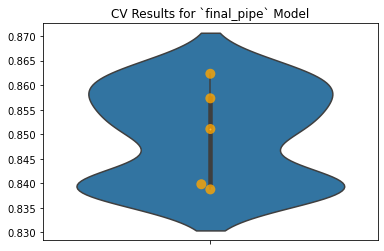

In [61]:
fig, ax = plt.subplots()

final_rt_pipe.plot_cv(ax=ax);

final_rt_pipe.print_cv_summary()

train_score = final_rt_model_pipe.score(X_train, y_train)
test_score = final_rt_model_pipe.score(X_test, y_test)
#score default is accuracy for a classifier

print(f' Train: {train_score}')
print(f' Test: {test_score}')

y_hat = final_rt_model_pipe.predict(X_test)
print(f'''Final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}''')

This model performs exceptionally better than the rest, however it is overfit for reasons described before. More robust data would have mitigated this.

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


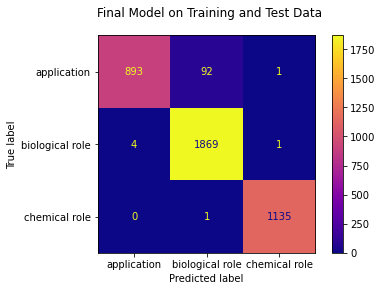

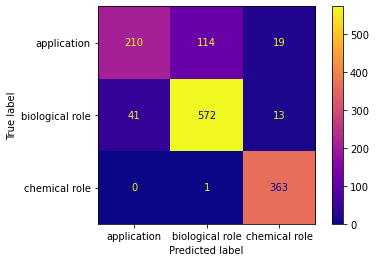

In [62]:
fig, ax = plt.subplots()

fig.suptitle("Final Model on Training and Test Data")

plot_confusion_matrix(final_rt_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

plot_confusion_matrix(final_rt_model_pipe, X_test, y_test, cmap="plasma");

Most of the errors occured when it was in fact an application, and the model predicted biological role. 

Interestingly, the model rarely mispredicted chemical role when it was truly an application.

## Role Type Feature Importances

Now that I have iterated and found my best model, I am interested in seeing which specific features affect the model performance (accuracy) when predicting the class.

In [63]:
# compiling a df which ranks the features importance by descending order

rfc_features = final_rt_model_pipe.feature_importances_

num_rt_features = grab_numeric_rt(X_train).columns

num_rt_list = list(num_rt_features)

features_rt_df = pd.DataFrame(rfc_features, num_rt_list, columns=['rfc_features'])

features_rt_df.sort_values(by='rfc_features', ascending=False).head(20)

,rfc_features
Complexity,0.146148
AtomStereoCount,0.138471
TPSA,0.088344
RotatableBondCount,0.060349
HBondAcceptorCount,0.057239
H,0.056422
C,0.051943
HBondDonorCount,0.048776
ExactMass,0.045339
MonoisotopicMass,0.044218


Looks like Complexity, stereoisomerism, and TPSA play key roles in this prediction.

In [64]:
# fitting unsplit data on the final model
final_rt_model_pipe.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=13, max_features=None,
                       n_estimators=10000, n_jobs=-1, random_state=42)

In [65]:
# saving the model to implement in streamlit
pickle.dump(final_rt_model_pipe, open('final_rt_model_pipe', 'wb'))

# Role Name Classification

## Role Name Data

When it comes to Role Name, I have a different approach than role type. There were only 3 classes for role type, while there are many for role name

In [37]:
clean_df.shape

(10137, 110)

In [38]:
# checking to see the value counts of each class of Role Name
clean_df.RoleName.value_counts()

metabolite                                            1573
plant metabolite                                      1453
human metabolite                                       730
mouse metabolite                                       580
epitope                                                500
                                                      ... 
ultraviolet filter                                       1
EC 3.1.26.13 (retroviral ribonuclease H) inhibitor       1
nicotinic antagonist                                     1
EC 1.3.1.72 (&#916;24-sterol reductase) inhibitor        1
adenosine A3 receptor agonist                            1
Name: RoleName, Length: 600, dtype: int64

Not only does Role Name have 600 classes, but some of them only occur once. This is almost acting like a unique identifier, which will negatively impact training.

I am removing any row which has a class that has less than 10 instances. If I had more data, there would be less instances of a class of role name only occuring once, and training would be better.

In [39]:
balanced_rn_df = clean_df[clean_df.groupby('RoleName').RoleName.transform('count')>9]
balanced_rn_df.RoleName.value_counts()

metabolite                          1573
plant metabolite                    1453
human metabolite                     730
mouse metabolite                     580
epitope                              500
                                    ... 
central nervous system stimulant      10
explosive                             10
insecticide                           10
anti-inflammatory agent               10
sedative                              10
Name: RoleName, Length: 88, dtype: int64

In [40]:
len(balanced_rn_df.RoleName.value_counts().index)

88

In [41]:
# grouping separate dfs by their specific role
bio_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'biological role']
chem_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'chemical role']
app_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'application']

In [42]:
balanced_rn_df.shape

(8898, 110)

In [49]:
print(bio_rn_df.RoleName.value_counts())
print(f' There are {len(bio_rn_df.RoleName.value_counts())} classes')

metabolite                                                              1573
plant metabolite                                                        1453
human metabolite                                                         730
mouse metabolite                                                         580
epitope                                                                  500
bacterial metabolite                                                     425
human xenobiotic metabolite                                              206
Caenorhabditis elegans metabolite                                        203
Saccharomyces cerevisiae metabolite                                      197
Escherichia coli metabolite                                              176
fungal metabolite                                                        120
Aspergillus metabolite                                                   117
Mycoplasma genitalium metabolite                                         105

In [50]:
print(chem_rn_df.RoleName.value_counts())
print(f' There are {len(chem_rn_df.RoleName.value_counts())} classes')

chelator       21
buffer         15
antioxidant    13
surfactant     11
explosive      10
Name: RoleName, dtype: int64
 There are 5 classes


In [51]:
print(app_rn_df.RoleName.value_counts())
print(f' There are {len(app_rn_df.RoleName.value_counts())} classes')

fluorochrome                        327
chromogenic compound                 97
antineoplastic agent                 77
antifungal agrochemical              61
histological dye                     46
herbicide                            25
dye                                  25
flavouring agent                     25
geroprotector                        22
fragrance                            21
fluorescent probe                    18
pyrethroid ester insecticide         17
fertilizer                           17
antidepressant                       16
radioopaque medium                   15
anti-inflammatory drug               14
local anaesthetic                    14
nutraceutical                        14
anti-arrhythmia drug                 13
vasodilator agent                    13
chromatographic reagent              12
antihypertensive agent               12
antiinfective agent                  11
anti-inflammatory agent              10
central nervous system stimulant     10


### Role Name Train-Test Split

The assumption here based on data collection is that each role name is associated with only one specific role type.

The first modeling section of this notebook predicts the Role Type, which is hierarchically higher than Role Name.
The data for this was more robust. Now that we have classes of Role Name with very low value counts, training gets a little more tricky.

The uncertainty in the model could be given a hint by the role type. 
Including the role type accounts for 5% more accuracy. However I don't want to provide the training 'hints'.
This is almost cheating because it uses a hierarchical information to inform the lower level of the hierarchy.
Therefore, I will remove Role Type in my training of the role name classifier models.

For comparison, I am going to keep the unsplit dataset to show that creating 3 different Role Name classifiers (one for each role type) performs better than one larger classifier.

In [76]:
# one large classifier, uses ungrouped df
X1 = balanced_rn_df.drop(['RoleName', 'RoleType', 'ChEBI'], axis=1)
y1 = balanced_rn_df['RoleName']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42)

In [77]:
# performs split on df grouped by biological role
X2 = bio_rn_df.drop(['RoleName', 'RoleType', 'ChEBI'], axis=1)
y2 = bio_rn_df['RoleName']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

In [78]:
# performs split on df grouped by chemical role
X3 = chem_rn_df.drop(['RoleName', 'RoleType', 'ChEBI'], axis=1)
y3 = chem_rn_df['RoleName']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)

In [79]:
# peforms split on df grouped by application
X4 = app_rn_df.drop(['RoleName', 'RoleType', 'ChEBI'], axis=1)
y4 = app_rn_df['RoleName']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state=42)

## Role Name Modelling

Just as for Role Type, I also want a pipeline for my Role Name classification models for ease of use and flow.

In [80]:
# function to grab numeric values from df
def grab_numeric_rn(df):
    return df.select_dtypes(include=['float', 'int'])

# applying it to FunctionTransformer, which is necessary for this pipeline
GrabNumeric_rn = FunctionTransformer(grab_numeric_rn)

subpipe_num = Pipeline(steps=[('get_num', GrabNumeric_rn),
                              ('ss', StandardScaler())])

# using a ColumnTransformer to integrate above into pipeline
ct = ColumnTransformer(transformers = [('subpipe_num', subpipe_num, X_train.columns)])

I'm breaking this up into the 4 train test splits I did, to see whether 3 classifiers work better than 1.

### Baseline Model Full Dataframe

Creating a baseline model to compare performance of model using full df

In [81]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X1_train, y1_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X1_train,
    y=y1_train)

CV Results for `dummy_model_pipe` model:
            0.17863 ± 0.00033 accuracy
        
 Train: 0.17863030121384685


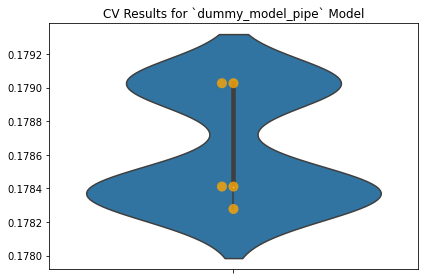

In [82]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

full_df_dummy_train_score = dummy_pipe.score(X1_train, y1_train)
print(f' Train: {full_df_dummy_train_score}')

### Baseline Model Bio

Creating baseline to compare performance of split done on bio df

In [83]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X2_train, y2_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X2_train,
    y=y2_train)

CV Results for `dummy_model_pipe` model:
            0.19909 ± 0.00030 accuracy
        
 Train: 0.19908583037074656


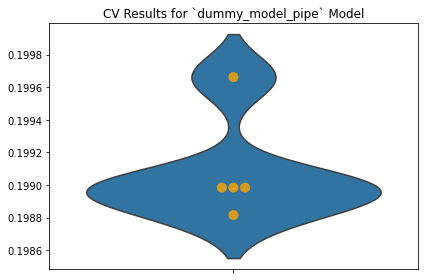

In [84]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

bio_df_dummy_train_score = dummy_pipe.score(X2_train, y2_train)
print(f' Train: {bio_df_dummy_train_score}')

### Baseline Model Chem

Creating a baseline model to compare performance of model using split done on chem df

In [85]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X3_train, y3_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X3_train,
    y=y3_train)

CV Results for `dummy_model_pipe` model:
            0.32727 ± 0.04706 accuracy
        
 Train: 0.3269230769230769


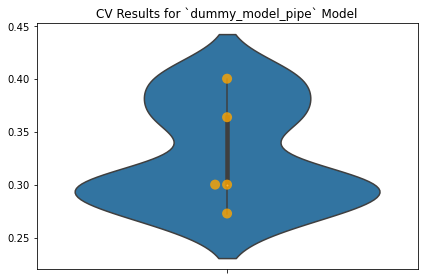

In [86]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

chem_df_dummy_train_score = dummy_pipe.score(X3_train, y3_train)
print(f' Train: {chem_df_dummy_train_score}')

### Baseline Model App

Creating baseline model to compare performance of model on split done with application df

In [87]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X4_train, y4_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X4_train,
    y=y4_train)

CV Results for `dummy_model_pipe` model:
            0.34874 ± 0.00319 accuracy
        
 Train: 0.3487394957983193


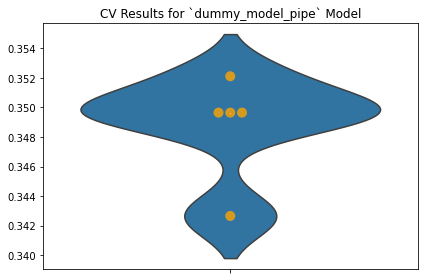

In [88]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

app_df_dummy_train_score = dummy_pipe.score(X4_train, y4_train)
print(f' Train: {app_df_dummy_train_score}')

### Logistic Regression Full Dataframe

Just as described in my iterative process for Role Type, I am iterating through my models in the same way. First starting with a distance based estimator. 

In [89]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X1_train, y1_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X1_train, 
                       y=y1_train)

CV Results for `log_pipe` model:
            0.39922 ± 0.00237 accuracy
        
 Train: 0.42439682301813275


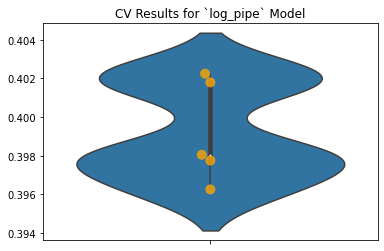

In [90]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

full_df_lr_train_score = logreg_model_pipe.score(X1_train, y1_train)
print(f' Train: {full_df_lr_train_score}')

Performance is not so great, not overfit either. Let's see how individual classifiers work instead of this larger one.

### Logistic Regression Bio

In [91]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X2_train, y2_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X2_train, 
                       y=y2_train)

CV Results for `log_pipe` model:
            0.41747 ± 0.00887 accuracy
        
 Train: 0.43473844591163024


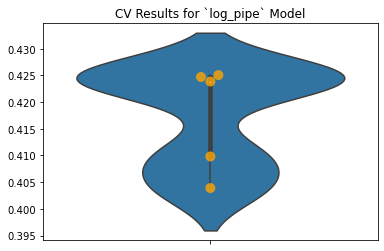

In [92]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

bio_df_lr_train_score = logreg_model_pipe.score(X2_train, y2_train)
print(f' Train: {bio_df_lr_train_score}')

Performs slightly better than unsplit data model.

### Logistic Regression Chem

In [93]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X3_train, y3_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X3_train, 
                       y=y3_train)

CV Results for `log_pipe` model:
            0.52182 ± 0.08750 accuracy
        
 Train: 0.9615384615384616


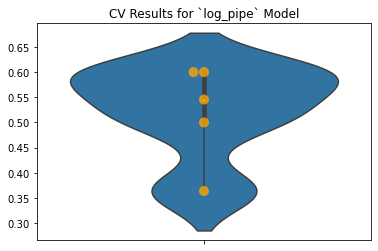

In [94]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

chem_df_lr_train_score = logreg_model_pipe.score(X3_train, y3_train)
print(f' Train: {chem_df_lr_train_score}')

Performs even better than unsplit data model.

### Logistic Regression App

In [95]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X1_train, y1_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X1_train, 
                       y=y1_train)

CV Results for `log_pipe` model:
            0.39922 ± 0.00237 accuracy
        
 Train: 0.42439682301813275


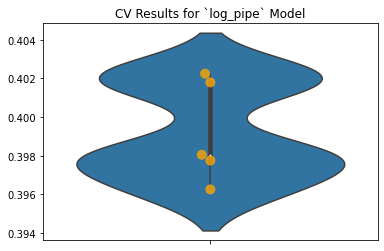

In [96]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

app_df_lr_train_score = logreg_model_pipe.score(X1_train, y1_train)
print(f' Train: {app_df_lr_train_score}')

Performs around the same as unsplit data model.

### Decision Trees Full Dataframe

Similar to my iterative process above, I would like to see how a tree based model performs on the 4 different splits/dfs.

In [97]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X1_train, y1_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X1_train,
                         y=y1_train)

CV Results for `dt_pipe` model:
            0.46905 ± 0.01110 accuracy
        
 Train: 0.9766222089015435


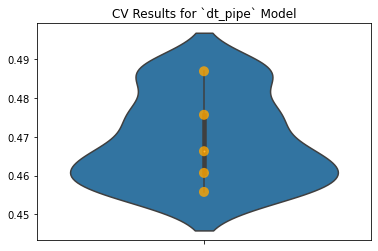

In [98]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

full_df_dt_train_score = dt_model_pipe.score(X1_train, y1_train)
print(f' Train: {full_df_dt_train_score}')

More accurate than logistic regression, but very overfit, which is expected

### Decision Trees Bio

In [99]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X2_train, y2_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X2_train,
                         y=y2_train)

CV Results for `dt_pipe` model:
            0.48130 ± 0.01241 accuracy
        
 Train: 0.9747756898594887


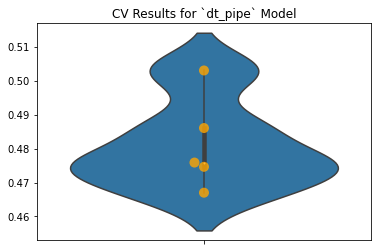

In [100]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

bio_df_dt_train_score = dt_model_pipe.score(X2_train, y2_train)
print(f' Train: {bio_df_dt_train_score}')

Performs better than model using unsplit df, yet overfit.

### Decision Trees Chem

In [101]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X3_train, y3_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X3_train,
                         y=y3_train)

CV Results for `dt_pipe` model:
            0.53818 ± 0.09679 accuracy
        
 Train: 1.0


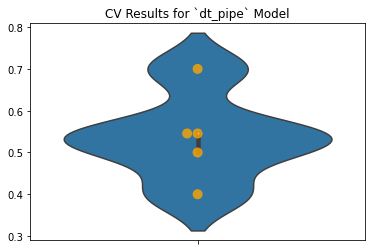

In [102]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

chem_df_dt_train_score = dt_model_pipe.score(X3_train, y3_train)
print(f' Train: {chem_df_dt_train_score}')

This also performs better than unsplit data. Going to address overfitting later.

### Decision Trees App

In [103]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X4_train, y4_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X4_train,
                         y=y4_train)

CV Results for `dt_pipe` model:
            0.53777 ± 0.03958 accuracy
        
 Train: 1.0


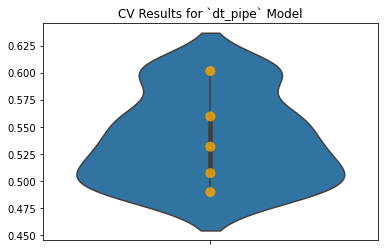

In [104]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

app_df_dt_train_score = dt_model_pipe.score(X4_train, y4_train)
print(f' Train: {app_df_dt_train_score}')

Performs much better than unsplit data however very overfit. 

Decision trees are outperforming logistic regression for all the classifiers. This is most likely because the question at hand is more comlicated than a sigmoid curve can account for. The nature in which decision trees work (as described above in the role type decision tree) account for this improvement. 

### Random Forest Full Dataframe

Adding complexity to see if it performs better than decision trees.

Since I already know Random Forests will perform better than decision trees, I am going to address overfitting here, instead of also for decision trees above.

At first I'll include max_depth parameters to address overfitting.

In [105]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(n_jobs=-1, n_estimators=10000, max_depth=20, random_state=42))])

rfc_model_pipe.fit(X1_train, y1_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X1_train, 
                          y=y1_train)

CV Results for `forest_pipe` model:
            0.56197 ± 0.00852 accuracy
        
 Train: 0.9659823167990409


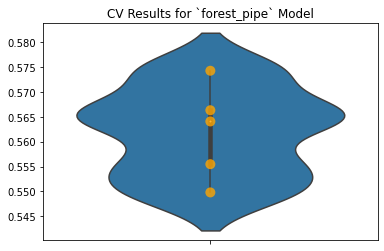

In [106]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

full_df_rf_train_score = rfc_model_pipe.score(X1_train, y1_train)
print(f' Train: {full_df_rf_train_score}')

This performs better than decision trees and logistic regression, however it is very overfit. Let's see how individual Role Name classifiers perform instead of an aggregated one.

### Random Forest Bio

For the same reason as above, I'm going to forgo using a pipeline for my randomf forest classifier. It does not need scaling, which is all I have in my pipeline, and streamlit doesn't work with this pipepline

In [107]:
# rfc_model_pipe = Pipeline(steps=[
#                 ('ct', ct), 
#                 ('rfc', RandomForestClassifier(n_jobs=-1, random_state=42))])

# rfc_model_pipe.fit(X2_train, y2_train)

rfc_bio_model = RandomForestClassifier(n_jobs=-1, n_estimators=10000, max_depth=13, random_state=42)

rfc_bio_model.fit(X2_train, y2_train)

rfc_bio_pipe = ModelWithCV(model=rfc_bio_model, 
                          model_name='rfc_bio_pipe', 
                          X=X2_train, 
                          y=y2_train)

CV Results for `rfc_bio_pipe` model:
            0.54884 ± 0.00734 accuracy
        
 Train: 0.7690875232774674


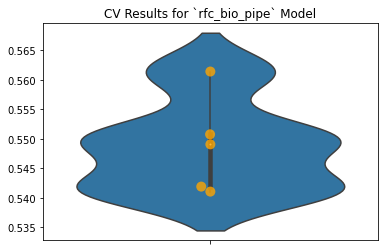

In [108]:
fig, ax = plt.subplots()

rfc_bio_pipe.plot_cv(ax=ax)

rfc_bio_pipe.print_cv_summary()

bio_df_rf_train_score = rfc_bio_model.score(X2_train, y2_train)
print(f' Train: {bio_df_rf_train_score}')

Performs around the same as unsplit data, but far less overfit. It's starting to look like I should in fact split the data and make 3 different classifiers

### Random Forest Chem

In [109]:
# rfc_model_pipe = Pipeline(steps=[
#                 ('ct', ct), 
#                 ('rfc', RandomForestClassifier(n_jobs=-1, random_state=42))])

# rfc_model_pipe.fit(X3_train, y3_train)



rfc_chem_model = RandomForestClassifier(n_jobs=-1, n_estimators=20000, max_depth=4, random_state=42)

rfc_chem_model.fit(X3_train, y3_train)

rfc_chem_pipe = ModelWithCV(model=rfc_chem_model, 
                          model_name='rfc_chem_pipe', 
                          X=X3_train, 
                          y=y3_train)

CV Results for `rfc_chem_pipe` model:
            0.42364 ± 0.15784 accuracy
        
 Train: 0.9807692307692307


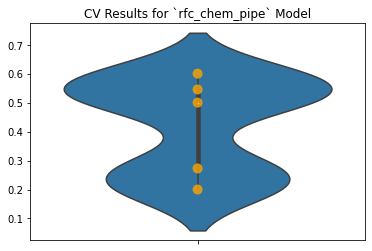

In [110]:
fig, ax = plt.subplots()

rfc_chem_pipe.plot_cv(ax=ax)

rfc_chem_pipe.print_cv_summary()

chem_df_rf_train_score = rfc_chem_model.score(X3_train, y3_train)
print(f' Train: {chem_df_rf_train_score}')

Performs a bit worse than model with unsplit data. This model is by far the most overfit, and has the worst accuracy of the random forests. This is due to the scarcity of chemical role compounds in the dataset.

### Random Forest App

In [111]:
# rfc_model_pipe = Pipeline(steps=[
#                 ('ct', ct), 
#                 ('rfc', RandomForestClassifier(random_state=42))])

# rfc_model_pipe.fit(X4_train, y4_train)


rfc_app_model = RandomForestClassifier(n_jobs=-1, n_estimators=10000, max_depth=9, random_state=42)

rfc_app_model.fit(X4_train, y4_train)

rfc_app_pipe = ModelWithCV(model=rfc_app_model, 
                          model_name='rfc_app_pipe', 
                          X=X4_train, 
                          y=y4_train)

CV Results for `rfc_app_pipe` model:
            0.62045 ± 0.03379 accuracy
        
 Train: 0.896358543417367


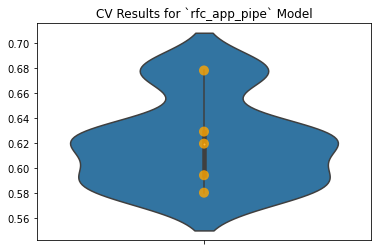

In [112]:
fig, ax = plt.subplots()

rfc_app_pipe.plot_cv(ax=ax)

rfc_app_pipe.print_cv_summary()

app_df_rf_train_score = rfc_app_model.score(X4_train, y4_train)
print(f' Train: {app_df_rf_train_score}')

Performs better than model using unsplit data, and signifincaly less overfit as well.

All random forest models perform better than their decision tree counterparts. This is because of that extra layer of randomization.

### Gradient Boosting Classifier Full Dataframe

Interested to see how another ensemble model works, just as iterated above for Role Type in the earlier part of the notebook.

In [113]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X1_train, y1_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X1_train,
                         y=y1_train)

[CV 4/5] END gbc__max_depth=10, gbc__n_estimators=100; accuracy: (test=0.849) neg_log_loss: (test=-0.393) total time=   7.4s
[CV 2/5] END gbc__max_depth=14, gbc__n_estimators=90; accuracy: (test=0.851) neg_log_loss: (test=-0.586) total time=  11.2s
[CV 4/5] END gbc__max_depth=14, gbc__n_estimators=110; accuracy: (test=0.857) neg_log_loss: (test=-0.610) total time=  13.2s
[CV 2/5] END gbc__max_depth=16, gbc__n_estimators=100; accuracy: (test=0.846) neg_log_loss: (test=-0.780) total time=  15.2s
[CV 2/5] END gbc__max_depth=10, gbc__n_estimators=100; accuracy: (test=0.855) neg_log_loss: (test=-0.416) total time=   7.4s
[CV 1/5] END gbc__max_depth=14, gbc__n_estimators=90; accuracy: (test=0.861) neg_log_loss: (test=-0.608) total time=  11.1s
[CV 2/5] END gbc__max_depth=14, gbc__n_estimators=110; accuracy: (test=0.850) neg_log_loss: (test=-0.652) total time=  13.4s
[CV 4/5] END gbc__max_depth=16, gbc__n_estimators=100; accuracy: (test=0.842) neg_log_loss: (test=-0.744) total time=  15.0s
[C

CV Results for `boost_pipe` model:
            0.29617 ± 0.23319 accuracy
        
 Train: 0.03656526300014986


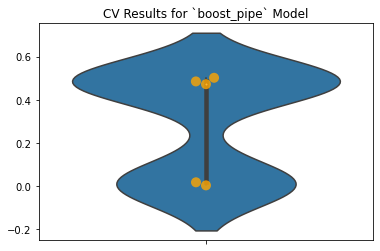

In [114]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

full_df_gbc_train_score = gbc_model_pipe.score(X1_train, y1_train)
print(f' Train: {full_df_gbc_train_score}')

Does not perform as expected. Lacking in accuracy.

### Gradient Boosting Classifier Bio

In [115]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X2_train, y2_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X2_train,
                         y=y2_train)

CV Results for `boost_pipe` model:
            0.40474 ± 0.19224 accuracy
        
 Train: 0.7802607076350093


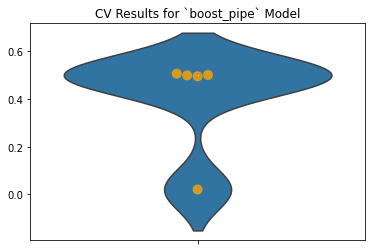

In [116]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

bio_df_gbc_train_score = gbc_model_pipe.score(X2_train, y2_train)
print(f' Train: {bio_df_gbc_train_score}')

Better than unsplit data.

Performs worse than random forest bio.

So far random forest classifier is the model to use for biological role type naming.

### Gradient Boosting Classifier Chem

In [117]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X3_train, y3_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X3_train,
                         y=y3_train)

CV Results for `boost_pipe` model:
            0.42727 ± 0.11296 accuracy
        
 Train: 1.0


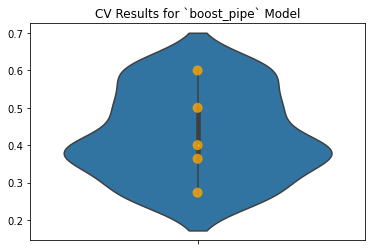

In [118]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

chem_df_gbc_train_score = gbc_model_pipe.score(X3_train, y3_train)
print(f' Train: {chem_df_gbc_train_score}')

Better than unsplit data, yet very overfit.

In fact, random forest performs better than this, and is slightly less overfit. 

So far, random forest is the classifier to use for chemical role as well. We will wait until grid search to make the final decision.

### Gradient Boosting Classifier App

In [119]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X4_train, y4_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X4_train,
                         y=y4_train)

CV Results for `boost_pipe` model:
            0.62745 ± 0.02810 accuracy
        
 Train: 1.0


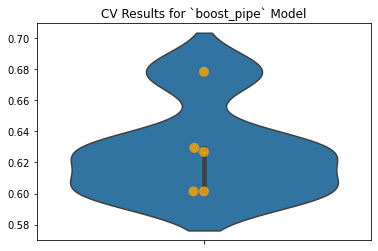

In [120]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

app_df_gbc_train_score = gbc_model_pipe.score(X4_train, y4_train)
print(f' Train: {app_df_gbc_train_score}')

Better than unsplit data, yet very overfit.

Again, random forest performs better for application and is also less overfit than gradient boost classifier.

Random forest and boosting classifier perform similarly on all role types except for biological role. Random forest performs better for biological role. 

For this reason, and since random forest is less computationaly expensive than gradient boosting classifier, random forest estimators are my go to for classifiying the name of each role type (biological, chemical, and application).

## Hyperparameter Tuning

## Grid Search

Random forest classifier and gradient boosting classifier were my two top performing models for bio, chem, and app roles. I will be performing grid search on all 3 classifiers on both estimators.

### RFC Grid Search

Since it's evident that creating 3 separate classifiers for role name performs better than one larger classifier, I am going to perform grid search on the specific bio, chem, and app models for both random forest and gradient boosting classifier

Since I have tweaked max_depth and n_estimators above to reduce overfitting, I am going to keep those parameters in place and run a grid search on other parameters instead.

#### Bio

In [121]:
params_rfc = {
        'max_features': ['sqrt', 'log2', None],
        'criterion' : ['gini', 'entropy']}

gs_rfc_bio = GridSearchCV(rfc_bio_model, 
                          params_rfc, 
                          scoring=['accuracy','neg_log_loss'],
                          refit='accuracy',
                          cv=5, 
                          verbose=3)

gs_rfc_bio.fit(X2_train, y2_train)

print(gs_rfc_bio.best_params_)
print(gs_rfc_bio.best_score_)
pd.DataFrame(gs_rfc_bio.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.549) neg_log_loss: (test=-1.745) total time=  20.8s
[CV 2/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.551) neg_log_loss: (test=-1.694) total time=  17.1s
[CV 3/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.541) neg_log_loss: (test=-1.699) total time=  17.2s
[CV 4/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.561) neg_log_loss: (test=-1.694) total time=  17.4s
[CV 5/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.542) neg_log_loss: (test=-1.705) total time=  16.8s
[CV 1/5] END criterion=gini, max_features=log2; accuracy: (test=0.535) neg_log_loss: (test=-1.799) total time=  14.3s
[CV 2/5] END criterion=gini, max_features=log2; accuracy: (test=0.534) neg_log_loss: (test=-1.757) total time=  14.4s
[CV 3/5] END criterion=gini, max_features=log2; accuracy: (test=0.529) neg_log_loss: (test=-1.759) total time=  14

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,14.033824,1.446035,3.806723,0.043755,gini,sqrt,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.549069,0.550761,0.541067,0.561389,0.541914,0.548840,0.007343,5,-1.744874,-1.694142,-1.698746,-1.694051,-1.704857,-1.707334,0.019181,3
1,10.411084,0.161346,3.766531,0.037141,gini,log2,"{'criterion': 'gini', 'max_features': 'log2'}",0.534687,0.533841,0.529213,0.548688,0.533446,0.535975,0.006632,6,-1.798830,-1.757182,-1.758869,-1.751132,-1.761619,-1.765526,0.017003,4
2,41.642159,0.503034,3.805077,0.029398,gini,None,"{'criterion': 'gini', 'max_features': None}",0.550761,0.551607,0.560542,0.567316,0.551228,0.556291,0.006599,4,-1.918776,-1.711358,-1.744846,-1.727508,-1.757555,-1.772009,0.075028,5
3,22.625808,1.030530,3.839679,0.017130,entropy,sqrt,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.579526,0.569374,0.563082,0.579170,0.566469,0.571524,0.006692,2,-1.766892,-1.675472,-1.649914,-1.706291,-1.657521,-1.691218,0.042528,2
4,17.023548,0.143606,3.791154,0.008784,entropy,log2,"{'criterion': 'entropy', 'max_features': 'log2'}",0.566836,0.555838,0.551228,0.566469,0.552921,0.558658,0.006693,3,-1.732645,-1.681644,-1.673836,-1.671838,-1.677229,-1.687439,0.022847,1
5,93.317960,0.759209,3.841351,0.033125,entropy,None,"{'criterion': 'entropy', 'max_features': None}",0.581218,0.582064,0.568163,0.583404,0.564776,0.575925,0.007826,1,-2.202189,-1.922637,-1.941722,-2.101237,-1.859377,-2.005432,0.126600,6


Fit 8 has the best performing accuracy.

#### Chem

In [122]:
params_rfc = {
        'max_features': ['sqrt', 'log2', None],
        'criterion' : ['gini', 'entropy']}

gs_rfc_chem = GridSearchCV(rfc_chem_model, 
                           params_rfc,
                           scoring=['accuracy','neg_log_loss'],
                           refit='accuracy',
                           cv=5, 
                           verbose=3)

gs_rfc_chem.fit(X3_train, y3_train)

print(gs_rfc_chem.best_params_)
print(gs_rfc_chem.best_score_)
pd.DataFrame(gs_rfc_chem.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.273) neg_log_loss: (test=-1.449) total time=   7.4s
[CV 2/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.545) neg_log_loss: (test=-1.259) total time=   7.2s
[CV 3/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.500) neg_log_loss: (test=-1.138) total time=   7.2s
[CV 4/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.600) neg_log_loss: (test=-1.109) total time=   7.2s
[CV 5/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.200) neg_log_loss: (test=-1.356) total time=   7.2s
[CV 1/5] END criterion=gini, max_features=log2; accuracy: (test=0.273) neg_log_loss: (test=-1.468) total time=   7.2s
[CV 2/5] END criterion=gini, max_features=log2; accuracy: (test=0.455) neg_log_loss: (test=-1.294) total time=   7.2s
[CV 3/5] END criterion=gini, max_features=log2; accuracy: (test=0.500) neg_log_loss: (test=-1.192) total time=   7

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,4.957350,0.036506,2.285276,0.028439,gini,sqrt,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.272727,0.545455,0.5,0.6,0.2,0.423636,0.157837,5,-1.448640,-1.259445,-1.138496,-1.108713,-1.356012,-1.262261,0.128397,5
1,4.906973,0.017431,2.290068,0.031641,gini,log2,"{'criterion': 'gini', 'max_features': 'log2'}",0.272727,0.454545,0.5,0.6,0.3,0.425455,0.123235,3,-1.467791,-1.294496,-1.192124,-1.135718,-1.371958,-1.292418,0.119750,6
2,5.075099,0.020904,2.266636,0.022216,gini,None,"{'criterion': 'gini', 'max_features': None}",0.181818,0.363636,0.6,0.5,0.4,0.409091,0.140366,6,-1.389097,-1.253723,-0.927467,-1.060368,-1.274647,-1.181060,0.165042,2
3,5.038558,0.072882,2.284368,0.015221,entropy,sqrt,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.181818,0.545455,0.5,0.6,0.3,0.425455,0.158443,3,-1.423104,-1.194287,-1.112761,-1.057445,-1.343546,-1.226229,0.137773,3
4,5.032146,0.138918,2.314622,0.037573,entropy,log2,"{'criterion': 'entropy', 'max_features': 'log2'}",0.272727,0.545455,0.5,0.6,0.3,0.443636,0.132540,2,-1.441114,-1.241342,-1.171598,-1.090825,-1.361114,-1.261199,0.126335,4
5,5.224540,0.015596,2.312689,0.035564,entropy,None,"{'criterion': 'entropy', 'max_features': None}",0.272727,0.454545,0.6,0.6,0.6,0.505455,0.129283,1,-1.420697,-1.039521,-0.887601,-0.925657,-1.262850,-1.107265,0.204093,1


The 8th fit ranks 1 for both accuracy and loss, so I will go with that one.

#### App

In [123]:
params_rfc = {
        'max_features': ['sqrt', 'log2', None],
        'criterion' : ['gini', 'entropy']}

gs_rfc_app = GridSearchCV(rfc_app_model, 
                          params_rfc, 
                          scoring=['accuracy','neg_log_loss'],
                          refit='accuracy',
                          cv=5, 
                          verbose=3)

gs_rfc_app.fit(X4_train, y4_train)

print(gs_rfc_app.best_params_)
print(gs_rfc_app.best_score_)
pd.DataFrame(gs_rfc_app.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.629) neg_log_loss: (test=-1.494) total time=   5.6s
[CV 2/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.594) neg_log_loss: (test=-1.485) total time=   5.5s
[CV 3/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.678) neg_log_loss: (test=-1.339) total time=   5.6s
[CV 4/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.580) neg_log_loss: (test=-1.471) total time=   5.6s
[CV 5/5] END criterion=gini, max_features=sqrt; accuracy: (test=0.620) neg_log_loss: (test=-1.498) total time=   5.5s
[CV 1/5] END criterion=gini, max_features=log2; accuracy: (test=0.615) neg_log_loss: (test=-1.541) total time=   5.4s
[CV 2/5] END criterion=gini, max_features=log2; accuracy: (test=0.566) neg_log_loss: (test=-1.548) total time=   5.4s
[CV 3/5] END criterion=gini, max_features=log2; accuracy: (test=0.650) neg_log_loss: (test=-1.394) total time=   5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,3.293939,0.041421,2.263213,0.018837,gini,sqrt,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.629371,0.594406,0.678322,0.580420,0.619718,0.620447,0.033793,5,-1.493717,-1.485088,-1.339223,-1.471482,-1.498198,-1.457542,0.059856,3
1,3.173912,0.039929,2.275320,0.036680,gini,log2,"{'criterion': 'gini', 'max_features': 'log2'}",0.615385,0.566434,0.650350,0.587413,0.605634,0.605043,0.028148,6,-1.540991,-1.547591,-1.393523,-1.521099,-1.551367,-1.510915,0.059617,5
2,5.550269,0.035598,2.238011,0.012135,gini,None,"{'criterion': 'gini', 'max_features': None}",0.608392,0.615385,0.692308,0.601399,0.619718,0.627440,0.033027,3,-1.435635,-1.485793,-1.329481,-1.489252,-1.419625,-1.431957,0.058048,1
3,3.928977,0.030583,2.272892,0.017564,entropy,sqrt,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.622378,0.608392,0.699301,0.601399,0.654930,0.637280,0.036062,2,-1.489685,-1.437145,-1.306090,-1.445472,-1.506003,-1.436879,0.070351,2
4,3.606592,0.032353,2.257828,0.007870,entropy,log2,"{'criterion': 'entropy', 'max_features': 'log2'}",0.622378,0.594406,0.685315,0.594406,0.633803,0.626061,0.033432,4,-1.522102,-1.492600,-1.345585,-1.489962,-1.538110,-1.477672,0.068480,4
5,9.349330,0.035270,2.255895,0.009807,entropy,None,"{'criterion': 'entropy', 'max_features': None}",0.636364,0.650350,0.706294,0.629371,0.619718,0.648419,0.030611,1,-1.482006,-1.452730,-1.355050,-1.611243,-1.664831,-1.513172,0.111576,6


I am going to pick the fit which maximizes accuracy, fit 8.

### GBC Grid Search

I am still curious to see which parameters grid search picks for my gradient boosting classifier, specfically for the below parameters.

#### Bio

In [124]:
params_gbc = {
    'gbc__n_estimators' : [250,275,300],
    'gbc__max_depth' : [5,6,7],
    'gbc__max_features': ['sqrt','log2',None]}

gs_gbc_bio = GridSearchCV(gbc_model_pipe, 
                          params_gbc,
                          scoring=['accuracy','neg_log_loss'],
                          refit='accuracy',
                          #n_jobs=-1, 
                          cv=5, 
                          verbose=3)

gs_gbc_bio.fit(X2_train, y2_train)

print(gs_gbc_bio.best_params_)
print(gs_gbc_bio.best_score_)
pd.DataFrame(gs_gbc_bio.cv_results_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END gbc__max_depth=5, gbc__max_features=sqrt, gbc__n_estimators=250; accuracy: (test=0.062) neg_log_loss: (test=-32.406) total time=  51.5s
[CV 2/5] END gbc__max_depth=5, gbc__max_features=sqrt, gbc__n_estimators=250; accuracy: (test=0.052) neg_log_loss: (test=-32.727) total time=  49.6s
[CV 3/5] END gbc__max_depth=5, gbc__max_features=sqrt, gbc__n_estimators=250; accuracy: (test=0.025) neg_log_loss: (test=-33.691) total time=  49.8s
[CV 4/5] END gbc__max_depth=5, gbc__max_features=sqrt, gbc__n_estimators=250; accuracy: (test=0.019) neg_log_loss: (test=-33.895) total time=  49.2s
[CV 5/5] END gbc__max_depth=5, gbc__max_features=sqrt, gbc__n_estimators=250; accuracy: (test=0.019) neg_log_loss: (test=-33.895) total time=  48.7s
[CV 1/5] END gbc__max_depth=5, gbc__max_features=sqrt, gbc__n_estimators=275; accuracy: (test=0.062) neg_log_loss: (test=-32.406) total time=  55.2s
[CV 2/5] END gbc__max_depth=5, gbc__max_feat

[CV 1/5] END gbc__max_depth=6, gbc__max_features=sqrt, gbc__n_estimators=300; accuracy: (test=0.054) neg_log_loss: (test=-32.669) total time= 1.1min
[CV 2/5] END gbc__max_depth=6, gbc__max_features=sqrt, gbc__n_estimators=300; accuracy: (test=0.008) neg_log_loss: (test=-34.247) total time= 1.1min
[CV 3/5] END gbc__max_depth=6, gbc__max_features=sqrt, gbc__n_estimators=300; accuracy: (test=0.038) neg_log_loss: (test=-33.223) total time= 1.1min
[CV 4/5] END gbc__max_depth=6, gbc__max_features=sqrt, gbc__n_estimators=300; accuracy: (test=0.046) neg_log_loss: (test=-32.960) total time= 1.1min
[CV 5/5] END gbc__max_depth=6, gbc__max_features=sqrt, gbc__n_estimators=300; accuracy: (test=0.078) neg_log_loss: (test=-31.848) total time= 1.1min
[CV 1/5] END gbc__max_depth=6, gbc__max_features=log2, gbc__n_estimators=250; accuracy: (test=0.013) neg_log_loss: (test=-34.100) total time=  46.3s
[CV 2/5] END gbc__max_depth=6, gbc__max_features=log2, gbc__n_estimators=250; accuracy: (test=0.014) neg_l

[CV 2/5] END gbc__max_depth=7, gbc__max_features=log2, gbc__n_estimators=275; accuracy: (test=0.066) neg_log_loss: (test=-32.260) total time= 1.1min
[CV 3/5] END gbc__max_depth=7, gbc__max_features=log2, gbc__n_estimators=275; accuracy: (test=0.040) neg_log_loss: (test=-33.164) total time= 1.0min
[CV 4/5] END gbc__max_depth=7, gbc__max_features=log2, gbc__n_estimators=275; accuracy: (test=0.057) neg_log_loss: (test=-32.579) total time= 1.0min
[CV 5/5] END gbc__max_depth=7, gbc__max_features=log2, gbc__n_estimators=275; accuracy: (test=0.069) neg_log_loss: (test=-32.170) total time=  57.5s
[CV 1/5] END gbc__max_depth=7, gbc__max_features=log2, gbc__n_estimators=300; accuracy: (test=0.043) neg_log_loss: (test=-33.049) total time= 1.1min
[CV 2/5] END gbc__max_depth=7, gbc__max_features=log2, gbc__n_estimators=300; accuracy: (test=0.066) neg_log_loss: (test=-32.260) total time= 1.1min
[CV 3/5] END gbc__max_depth=7, gbc__max_features=log2, gbc__n_estimators=300; accuracy: (test=0.040) neg_l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbc__max_depth,param_gbc__max_features,param_gbc__n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,49.134925,0.925836,0.626331,0.014055,5,sqrt,250,"{'gbc__max_depth': 5, 'gbc__max_features': 'sq...",0.061760,0.052453,0.024555,0.018628,0.018628,0.035205,0.018252,19,-32.405671,-32.727098,-33.690661,-33.895378,-33.895378,-33.322837,0.630397,19
1,53.170222,0.767640,0.681114,0.008636,5,sqrt,275,"{'gbc__max_depth': 5, 'gbc__max_features': 'sq...",0.061760,0.052453,0.024555,0.018628,0.018628,0.035205,0.018252,19,-32.405671,-32.727098,-33.690661,-33.895378,-33.895378,-33.322837,0.630397,19
2,57.748110,1.033528,0.740421,0.010212,5,sqrt,300,"{'gbc__max_depth': 5, 'gbc__max_features': 'sq...",0.061760,0.052453,0.024555,0.018628,0.018628,0.035205,0.018252,19,-32.405671,-32.727098,-33.690661,-33.895378,-33.895378,-33.322837,0.630397,19
3,42.108195,0.473869,0.580763,0.010292,5,log2,250,"{'gbc__max_depth': 5, 'gbc__max_features': 'lo...",0.021997,0.066836,0.000847,0.033870,0.037257,0.032161,0.021518,22,-33.779040,-32.230347,-34.509531,-33.368962,-33.251980,-33.427972,0.743206,22
4,46.222793,0.524820,0.635513,0.011495,5,log2,275,"{'gbc__max_depth': 5, 'gbc__max_features': 'lo...",0.021997,0.066836,0.000847,0.033870,0.037257,0.032161,0.021518,22,-33.779040,-32.230347,-34.509531,-33.368962,-33.251980,-33.427972,0.743206,22
5,50.481548,0.813284,0.691883,0.015193,5,log2,300,"{'gbc__max_depth': 5, 'gbc__max_features': 'lo...",0.021997,0.066836,0.000847,0.033870,0.037257,0.032161,0.021518,22,-33.779040,-32.230347,-34.509531,-33.368962,-33.251980,-33.427972,0.743206,22
6,176.228256,2.731215,0.485135,0.007160,5,None,250,"{'gbc__max_depth': 5, 'gbc__max_features': Non...",0.548223,0.540609,0.535140,0.552921,0.527519,0.540883,0.009060,3,-4.000764,-3.910611,-4.080585,-3.727011,-4.170877,-3.977969,0.152171,1
7,190.484479,2.937887,0.559447,0.040036,5,None,275,"{'gbc__max_depth': 5, 'gbc__max_features': Non...",0.546531,0.538071,0.535140,0.550381,0.529213,0.539867,0.007669,5,-4.101784,-3.975404,-4.160639,-3.823982,-4.248622,-4.062086,0.148520,2
8,206.331713,3.700391,0.554158,0.004419,5,None,300,"{'gbc__max_depth': 5, 'gbc__max_features': Non...",0.549915,0.535533,0.531753,0.551228,0.528366,0.539359,0.009441,6,-4.184035,-4.035918,-4.229275,-3.921650,-4.311776,-4.136531,0.139904,3
9,56.173658,1.029931,0.758975,0.016595,6,sqrt,250,"{'gbc__max_depth': 6, 'gbc__max_features': 'sq...",0.054146,0.008460,0.038103,0.045724,0.077900,0.044867,0.022580,16,-32.668657,-34.246570,-33.222735,-32.959527,-31.848203,-32.989138,0.779875,16


#### Chem

In [125]:
params_gbc = {
    'gbc__n_estimators' : [80,90,100],
    'gbc__max_depth' : [8,10,12],
    'gbc__max_features': ['sqrt','log2',None]}

gs_gbc_chem = GridSearchCV(gbc_model_pipe, 
                           params_gbc, 
                           scoring=['accuracy','neg_log_loss'],
                           refit='accuracy',
                           #n_jobs=-1, 
                           cv=5, 
                           verbose=3)

gs_gbc_chem.fit(X3_train, y3_train)

print(gs_gbc_chem.best_params_)
print(gs_gbc_chem.best_score_)
pd.DataFrame(gs_gbc_chem.cv_results_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END gbc__max_depth=8, gbc__max_features=sqrt, gbc__n_estimators=80; accuracy: (test=0.182) neg_log_loss: (test=-4.272) total time=   0.3s
[CV 2/5] END gbc__max_depth=8, gbc__max_features=sqrt, gbc__n_estimators=80; accuracy: (test=0.636) neg_log_loss: (test=-1.915) total time=   0.3s
[CV 3/5] END gbc__max_depth=8, gbc__max_features=sqrt, gbc__n_estimators=80; accuracy: (test=0.600) neg_log_loss: (test=-1.816) total time=   0.3s
[CV 4/5] END gbc__max_depth=8, gbc__max_features=sqrt, gbc__n_estimators=80; accuracy: (test=0.600) neg_log_loss: (test=-1.654) total time=   0.3s
[CV 5/5] END gbc__max_depth=8, gbc__max_features=sqrt, gbc__n_estimators=80; accuracy: (test=0.500) neg_log_loss: (test=-2.839) total time=   0.3s
[CV 1/5] END gbc__max_depth=8, gbc__max_features=sqrt, gbc__n_estimators=90; accuracy: (test=0.273) neg_log_loss: (test=-4.800) total time=   0.3s
[CV 2/5] END gbc__max_depth=8, gbc__max_features=sqrt, g

[CV 2/5] END gbc__max_depth=10, gbc__max_features=sqrt, gbc__n_estimators=100; accuracy: (test=0.636) neg_log_loss: (test=-2.421) total time=   0.4s
[CV 3/5] END gbc__max_depth=10, gbc__max_features=sqrt, gbc__n_estimators=100; accuracy: (test=0.600) neg_log_loss: (test=-1.941) total time=   0.4s
[CV 4/5] END gbc__max_depth=10, gbc__max_features=sqrt, gbc__n_estimators=100; accuracy: (test=0.600) neg_log_loss: (test=-1.640) total time=   0.4s
[CV 5/5] END gbc__max_depth=10, gbc__max_features=sqrt, gbc__n_estimators=100; accuracy: (test=0.400) neg_log_loss: (test=-3.321) total time=   0.4s
[CV 1/5] END gbc__max_depth=10, gbc__max_features=log2, gbc__n_estimators=80; accuracy: (test=0.364) neg_log_loss: (test=-3.709) total time=   0.3s
[CV 2/5] END gbc__max_depth=10, gbc__max_features=log2, gbc__n_estimators=80; accuracy: (test=0.636) neg_log_loss: (test=-1.956) total time=   0.3s
[CV 3/5] END gbc__max_depth=10, gbc__max_features=log2, gbc__n_estimators=80; accuracy: (test=0.700) neg_log

[CV 3/5] END gbc__max_depth=12, gbc__max_features=log2, gbc__n_estimators=90; accuracy: (test=0.500) neg_log_loss: (test=-1.576) total time=   0.4s
[CV 4/5] END gbc__max_depth=12, gbc__max_features=log2, gbc__n_estimators=90; accuracy: (test=0.600) neg_log_loss: (test=-1.268) total time=   0.3s
[CV 5/5] END gbc__max_depth=12, gbc__max_features=log2, gbc__n_estimators=90; accuracy: (test=0.400) neg_log_loss: (test=-3.026) total time=   0.4s
[CV 1/5] END gbc__max_depth=12, gbc__max_features=log2, gbc__n_estimators=100; accuracy: (test=0.273) neg_log_loss: (test=-4.228) total time=   0.4s
[CV 2/5] END gbc__max_depth=12, gbc__max_features=log2, gbc__n_estimators=100; accuracy: (test=0.545) neg_log_loss: (test=-2.369) total time=   0.4s
[CV 3/5] END gbc__max_depth=12, gbc__max_features=log2, gbc__n_estimators=100; accuracy: (test=0.500) neg_log_loss: (test=-1.714) total time=   0.4s
[CV 4/5] END gbc__max_depth=12, gbc__max_features=log2, gbc__n_estimators=100; accuracy: (test=0.600) neg_log

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbc__max_depth,param_gbc__max_features,param_gbc__n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,0.297763,0.003795,0.004686,0.000120,8,sqrt,80,"{'gbc__max_depth': 8, 'gbc__max_features': 'sq...",0.181818,0.636364,0.6,0.6,0.5,0.503636,0.167194,19,-4.271731,-1.914667,-1.816434,-1.654212,-2.838956,-2.499200,0.977666,9
1,0.337399,0.003946,0.004948,0.000282,8,sqrt,90,"{'gbc__max_depth': 8, 'gbc__max_features': 'sq...",0.272727,0.636364,0.6,0.6,0.5,0.521818,0.132565,14,-4.799589,-2.093258,-1.957085,-1.867021,-3.148484,-2.773087,1.113249,15
2,0.358981,0.003967,0.004673,0.000048,8,sqrt,100,"{'gbc__max_depth': 8, 'gbc__max_features': 'sq...",0.181818,0.636364,0.6,0.6,0.5,0.503636,0.167194,19,-5.291004,-2.316810,-2.115397,-1.975149,-3.533793,-3.046431,1.250795,18
3,0.285761,0.003206,0.004720,0.000307,8,log2,80,"{'gbc__max_depth': 8, 'gbc__max_features': 'lo...",0.181818,0.727273,0.6,0.6,0.5,0.521818,0.184669,13,-3.563095,-1.745381,-1.399922,-1.451768,-2.558078,-2.143649,0.821830,1
4,0.318865,0.002655,0.004612,0.000085,8,log2,90,"{'gbc__max_depth': 8, 'gbc__max_features': 'lo...",0.272727,0.727273,0.6,0.6,0.5,0.540000,0.151859,11,-3.829401,-1.872994,-1.531953,-1.552957,-2.877100,-2.332881,0.894093,4
5,0.352787,0.003333,0.004718,0.000072,8,log2,100,"{'gbc__max_depth': 8, 'gbc__max_features': 'lo...",0.272727,0.727273,0.6,0.6,0.4,0.520000,0.162053,16,-4.228165,-2.107739,-1.658397,-1.721023,-3.118875,-2.566840,0.981447,11
6,0.245180,0.023169,0.004288,0.000106,8,None,80,"{'gbc__max_depth': 8, 'gbc__max_features': Non...",0.363636,0.545455,0.4,0.8,0.7,0.561818,0.168258,6,-6.164252,-3.160407,-3.382303,-1.854904,-3.029119,-3.518197,1.425049,21
7,0.263666,0.024715,0.004263,0.000063,8,None,90,"{'gbc__max_depth': 8, 'gbc__max_features': Non...",0.363636,0.545455,0.4,0.8,0.7,0.561818,0.168258,6,-6.788005,-3.501764,-3.590286,-2.109502,-3.400349,-3.877981,1.552302,24
8,0.281604,0.025073,0.004313,0.000037,8,None,100,"{'gbc__max_depth': 8, 'gbc__max_features': Non...",0.363636,0.545455,0.4,0.8,0.7,0.561818,0.168258,6,-7.455983,-3.979354,-3.830242,-2.315236,-3.732712,-4.262706,1.705161,27
9,0.325263,0.017631,0.004836,0.000182,10,sqrt,80,"{'gbc__max_depth': 10, 'gbc__max_features': 's...",0.272727,0.636364,0.6,0.6,0.4,0.501818,0.141585,22,-3.991181,-1.974151,-1.678448,-1.378775,-2.780805,-2.360672,0.939577,7


#### App

In [129]:
params_gbc = {
    'gbc__n_estimators' : [1250,1500,1750],
    'gbc__max_depth' : [2,3,4],
    'gbc__max_features': ['sqrt','log2',None]}

gs_gbc_app = GridSearchCV(gbc_model_pipe, 
                          params_gbc,
                          scoring=['accuracy','neg_log_loss'],
                          refit='accuracy',
                          n_jobs=-1, 
                          cv=5, 
                          verbose=3)

gs_gbc_app.fit(X4_train, y4_train)

print(gs_gbc_app.best_params_)
print(gs_gbc_bio.best_score_)
pd.DataFrame(gs_gbc_app.cv_results_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'gbc__max_depth': 2, 'gbc__max_features': 'log2', 'gbc__n_estimators': 1250}
0.5425782733093495


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbc__max_depth,param_gbc__max_features,param_gbc__n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,18.009074,0.198549,0.084209,0.009353,2,sqrt,1250,"{'gbc__max_depth': 2, 'gbc__max_features': 'sq...",0.671329,0.594406,0.706294,0.636364,0.647887,0.651256,0.037141,16,-4.195684,-4.093534,-3.395843,-4.193181,-3.853004,-3.946249,0.302168,11
1,21.090314,0.193423,0.095000,0.010738,2,sqrt,1500,"{'gbc__max_depth': 2, 'gbc__max_features': 'sq...",0.671329,0.594406,0.699301,0.636364,0.640845,0.648449,0.035310,18,-4.466599,-4.331433,-3.669666,-4.462777,-4.139481,-4.213991,0.297099,17
2,23.766790,0.170543,0.104099,0.011653,2,sqrt,1750,"{'gbc__max_depth': 2, 'gbc__max_features': 'sq...",0.671329,0.608392,0.699301,0.643357,0.633803,0.651236,0.031355,17,-4.674791,-4.519167,-3.859985,-4.683721,-4.352597,-4.418052,0.304119,18
3,17.446628,0.111954,0.086913,0.005668,2,log2,1250,"{'gbc__max_depth': 2, 'gbc__max_features': 'lo...",0.671329,0.629371,0.692308,0.643357,0.669014,0.661076,0.022193,1,-3.967508,-3.448651,-2.982051,-3.934749,-3.766928,-3.619977,0.368173,4
4,20.523558,0.042137,0.096387,0.006806,2,log2,1500,"{'gbc__max_depth': 2, 'gbc__max_features': 'lo...",0.664336,0.629371,0.685315,0.643357,0.654930,0.655461,0.018961,10,-4.268151,-3.825323,-3.295694,-4.255420,-4.093178,-3.947553,0.362941,12
5,23.624568,0.182645,0.104633,0.004822,2,log2,1750,"{'gbc__max_depth': 2, 'gbc__max_features': 'lo...",0.664336,0.622378,0.685315,0.636364,0.654930,0.652664,0.021865,15,-4.487124,-4.056458,-3.513000,-4.510570,-4.395792,-4.192589,0.376703,16
6,32.923164,0.217911,0.066955,0.006201,2,None,1250,"{'gbc__max_depth': 2, 'gbc__max_features': Non...",0.636364,0.615385,0.657343,0.622378,0.633803,0.633054,0.014336,27,-5.612226,-5.054894,-4.448187,-5.065798,-5.012784,-5.038778,0.368593,25
7,36.825415,0.199560,0.084767,0.014527,2,None,1500,"{'gbc__max_depth': 2, 'gbc__max_features': Non...",0.650350,0.608392,0.664336,0.622378,0.640845,0.637260,0.019860,23,-5.778242,-5.217672,-4.525473,-5.214907,-5.200371,-5.187333,0.397261,26
8,40.600175,0.565762,0.073093,0.011935,2,None,1750,"{'gbc__max_depth': 2, 'gbc__max_features': Non...",0.643357,0.608392,0.678322,0.629371,0.640845,0.640057,0.022771,22,-5.772535,-5.253799,-4.541592,-5.259937,-5.228335,-5.211240,0.391907,27
9,18.228031,0.086367,0.083630,0.010936,3,sqrt,1250,"{'gbc__max_depth': 3, 'gbc__max_features': 'sq...",0.657343,0.636364,0.706294,0.622378,0.654930,0.655461,0.028450,10,-4.151700,-4.096274,-3.352579,-4.266633,-3.743841,-3.922206,0.334032,10


My random forest models all performed better, if not the same as gradient boosting classifier. Random forest are less computationaly expensive so I will go with those. Additionally, all models were less overfit when using random forest.

Bio random forest performed 3% better than bio gradient boost.

App random forest performed 10% better than app gradient boost. 

### Final Models

In [130]:
# setting the best parameters for the final models, respectively.

final_rn_bio_model_pipe = gs_rfc_bio.best_estimator_

final_rn_chem_model_pipe = gs_rfc_chem.best_estimator_

final_rn_app_model_pipe = gs_rfc_app.best_estimator_

## Role Name Classification Evaluation

### Final Role Name Bio Model 

In [131]:
# visualizing and plotting the final model
final_rn_bio_pipe = ModelWithCV(model=final_rn_bio_model_pipe,
                         model_name='final_rn_bio_pipe',
                         X=X2_train,
                         y=y2_train)

CV Results for `final_rn_bio_pipe` model:
            0.57592 ± 0.00783 accuracy
        
 Train: 0.9514135771119011
 Test: 0.5652615540883698
Final bio model's accuracy on the test set is 0.57


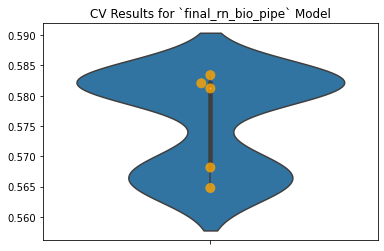

In [132]:
fig, ax = plt.subplots()

final_rn_bio_pipe.plot_cv(ax=ax);

final_rn_bio_pipe.print_cv_summary()

train_score = final_rn_bio_model_pipe.score(X2_train, y2_train)
test_score = final_rn_bio_model_pipe.score(X2_test, y2_test)

print(f' Train: {train_score}')
print(f' Test: {test_score}')

y2_hat = final_rn_bio_model_pipe.predict(X2_test)
print(f'''Final bio model's accuracy on the test set is {round(accuracy_score(y2_test, y2_hat), 2)}''')

Performs better than baseline, however, due to minimal data, the accuracy is not great. Not as overfit as I expected, which is great. 

### Final Role Name Chem Model

In [133]:
# visualizing and plotting the final model

final_rn_chem_pipe = ModelWithCV(model=final_rn_chem_model_pipe,
                         model_name='final_rn_chem_pipe',
                         X=X3_train,
                         y=y3_train)

CV Results for `final_rn_chem_pipe` model:
            0.50545 ± 0.12928 accuracy
        
 Train: 1.0
 Test: 0.7777777777777778
Final chem model's accuracy on the test set is 0.78


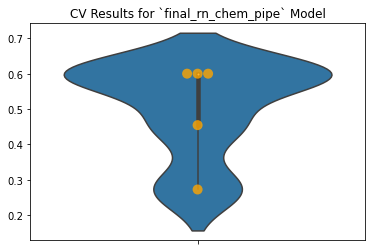

In [134]:
fig, ax = plt.subplots()

final_rn_chem_pipe.plot_cv(ax=ax);

final_rn_chem_pipe.print_cv_summary()

train_score = final_rn_chem_model_pipe.score(X3_train, y3_train)
test_score = final_rn_chem_model_pipe.score(X3_test, y3_test)

print(f' Train: {train_score}')
print(f' Test: {test_score}')

y3_hat = final_rn_chem_model_pipe.predict(X3_test)
print(f'''Final chem model's accuracy on the test set is {round(accuracy_score(y3_test, y3_hat), 2)}''')

Performs significanly better than expected, yet very overfit for same reason as above.

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


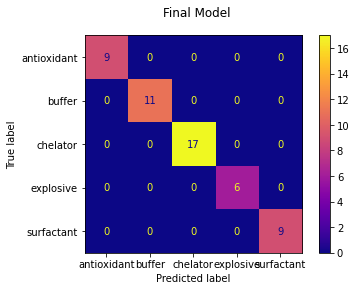

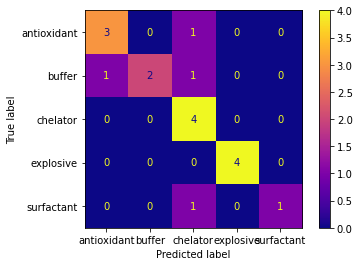

In [135]:
fig, ax = plt.subplots()

fig.suptitle("Final Model")

plot_confusion_matrix(final_rn_chem_model_pipe, X3_train, y3_train, ax=ax, cmap="plasma");

plot_confusion_matrix(final_rn_chem_model_pipe, X3_test, y3_test, cmap="plasma");

### Final Role Name App Model

In [136]:
# visualizing and plotting the final model

final_rn_app_pipe = ModelWithCV(model=final_rn_app_model_pipe,
                         model_name='final_rn_app_pipe',
                         X=X4_train,
                         y=y4_train)

CV Results for `final_rn_app_pipe` model:
            0.64842 ± 0.03061 accuracy
        
 Train: 1.0
 Test: 0.6470588235294118
Final app model's accuracy on the test set is 0.65


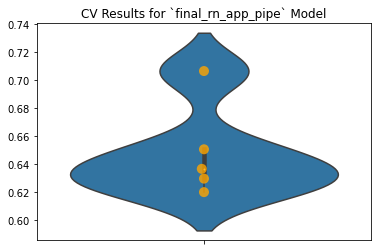

In [137]:
fig, ax = plt.subplots()

final_rn_app_pipe.plot_cv(ax=ax);

final_rn_app_pipe.print_cv_summary()

train_score = final_rn_app_model_pipe.score(X4_train, y4_train)
test_score = final_rn_app_model_pipe.score(X4_test, y4_test)

print(f' Train: {train_score}')
print(f' Test: {test_score}')

y4_hat = final_rn_app_model_pipe.predict(X4_test)
print(f'''Final app model's accuracy on the test set is {round(accuracy_score(y4_test, y4_hat), 2)}''')

Performs better than expected, yet very overfit due to sparse data.

/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/meiralelov/opt/anaconda3/envs/capstone-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


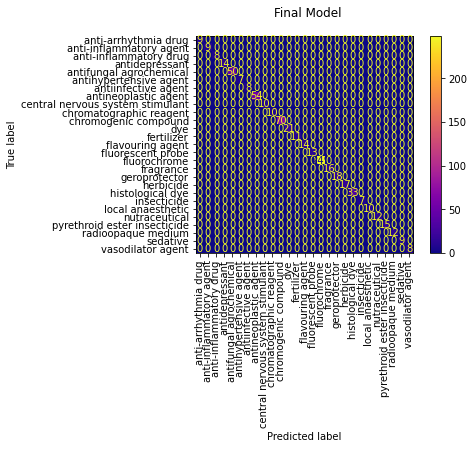

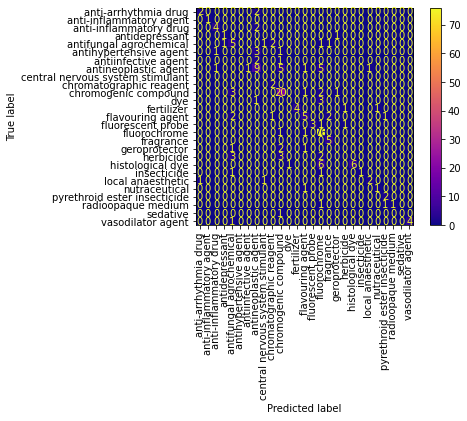

In [138]:
fig, ax = plt.subplots()

fig.suptitle("Final Model")

plot_confusion_matrix(final_rn_app_model_pipe, X4_train, y4_train, 
                      xticks_rotation='vertical', ax=ax, cmap="plasma");

plot_confusion_matrix(final_rn_app_model_pipe, X4_test, y4_test, 
                      xticks_rotation='vertical', cmap="plasma");

## Role Name Feature Importances

### Role Name Bio Features

In [139]:
# compiling a df specific to biological roles, showing the feature importances for naming.

rfc_features = final_rn_bio_model_pipe.feature_importances_

num_rn_features = grab_numeric_rn(X2_train).columns

num_rn_list = list(num_rn_features)

features_rn_df = pd.DataFrame(rfc_features, num_rn_list, columns=['rfc_features'])

features_rn_df.sort_values(by='rfc_features', ascending=False).head(20)

,rfc_features
Complexity,0.121835
RotatableBondCount,0.120804
TPSA,0.077018
DefinedAtomStereoCount,0.072353
N,0.072290
H,0.069928
C,0.067091
XLogP_qcut,0.066034
ExactMass,0.037901
MonoisotopicMass,0.037875


Complexity, rotatable bond count, TPSA, and hydrogen/carbon counts are important for biological role names

In [140]:
# fitting final model on data
final_rn_bio_model_pipe.fit(X2, y2)

RandomForestClassifier(criterion='entropy', max_depth=13, max_features=None,
                       n_estimators=10000, n_jobs=-1, random_state=42)

In [141]:
# saving model to use in streamlit
pickle.dump(final_rn_bio_model_pipe, open('final_rn_bio_model_pipe', 'wb'))

### Role Name Chem Features

In [142]:
# compiling a df specific to chemical roles, showing the feature importances for naming.

rfc_features = final_rn_chem_model_pipe.feature_importances_

num_rn_features = grab_numeric_rn(X3_train).columns

num_rn_list = list(num_rn_features)

features_rn_df = pd.DataFrame(rfc_features, num_rn_list, columns=['rfc_features'])

features_rn_df.sort_values(by='rfc_features', ascending=False).head(20)

,rfc_features
TPSA,0.142682
RotatableBondCount,0.134905
N,0.133132
H,0.124183
HBondDonorCount,0.102920
C,0.081437
DefinedAtomStereoCount,0.055405
Complexity,0.039205
AtomStereoCount,0.029210
HeavyAtomCount,0.028150


Complexity, mass, carbon count, and hydrogen count are important for classifying chem role types

In [143]:
# fitting final model on data
final_rn_chem_model_pipe.fit(X3, y3)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=None,
                       n_estimators=20000, n_jobs=-1, random_state=42)

In [144]:
# saving model to use in streamlit
pickle.dump(final_rn_chem_model_pipe, open('final_rn_chem_model_pipe', 'wb'))

### Role Name App Features

In [145]:
# compiling a df specific to medical applications, showing the feature importances for naming.

rfc_features = final_rn_app_model_pipe.feature_importances_

num_rn_features = grab_numeric_rn(X4_train).columns

num_rn_list = list(num_rn_features)

features_rn_df = pd.DataFrame(rfc_features, num_rn_list, columns=['rfc_features'])

features_rn_df.sort_values(by='rfc_features', ascending=False).head(20)

,rfc_features
Complexity,0.142597
C,0.124191
DefinedAtomStereoCount,0.084584
TPSA,0.082319
H,0.081136
AtomStereoCount,0.064194
HBondDonorCount,0.062707
N,0.053098
RotatableBondCount,0.047940
MonoisotopicMass,0.038151


Interesting to note that Complexity is the top feature for all classifiers.

For app model, mass, heavy atom count and carbon count are important.

In [146]:
# fitting final model on data
final_rn_app_model_pipe.fit(X4, y4)

RandomForestClassifier(criterion='entropy', max_depth=9, max_features=None,
                       n_estimators=10000, n_jobs=-1, random_state=42)

In [147]:
# saving model to use in streamlit
pickle.dump(final_rn_app_model_pipe, open('final_rn_app_model_pipe', 'wb'))

In [148]:
# commit changes to github

# in the readme,
    ## directory structure

# add to evaluation

    # talk about why accuracy is the main metric

    # how does this solve real life problem?

    # what are the consequences of errors?
    
    # how did the final models compare to the baselines?

# create visualizations
    
# env instructions
    # This project was built in a virutal env using anocanda 
    # you can find the necessary packages to recreate this env in the env.yml file
    # anocando package manager to compile virtual env
    # streamlit also works in this env 
    # conda env create -f environment.yml
    
    
    
# make streamlit pretty

## Conclusions

In [149]:
#How would you recommend that your model be used?
#Conclusion summarizes implications of the project for the real-world problem and stakeholders 

[CV 3/5] END gbc__max_depth=2, gbc__max_features=sqrt, gbc__n_estimators=1500; accuracy: (test=0.699) neg_log_loss: (test=-3.670) total time=  21.2s
[CV 2/5] END gbc__max_depth=2, gbc__max_features=log2, gbc__n_estimators=1250; accuracy: (test=0.629) neg_log_loss: (test=-3.449) total time=  17.4s
[CV 2/5] END gbc__max_depth=2, gbc__max_features=log2, gbc__n_estimators=1500; accuracy: (test=0.629) neg_log_loss: (test=-3.825) total time=  20.6s
[CV 2/5] END gbc__max_depth=2, gbc__max_features=None, gbc__n_estimators=1250; accuracy: (test=0.615) neg_log_loss: (test=-5.055) total time=  33.1s
[CV 2/5] END gbc__max_depth=2, gbc__max_features=None, gbc__n_estimators=1750; accuracy: (test=0.608) neg_log_loss: (test=-5.254) total time=  40.7s
[CV 3/5] END gbc__max_depth=3, gbc__max_features=sqrt, gbc__n_estimators=1750; accuracy: (test=0.706) neg_log_loss: (test=-3.353) total time=  23.9s
[CV 4/5] END gbc__max_depth=3, gbc__max_features=log2, gbc__n_estimators=1500; accuracy: (test=0.636) neg_

[CV 2/5] END gbc__max_depth=2, gbc__max_features=sqrt, gbc__n_estimators=1500; accuracy: (test=0.594) neg_log_loss: (test=-4.331) total time=  21.5s
[CV 3/5] END gbc__max_depth=2, gbc__max_features=log2, gbc__n_estimators=1250; accuracy: (test=0.692) neg_log_loss: (test=-2.982) total time=  17.4s
[CV 3/5] END gbc__max_depth=2, gbc__max_features=log2, gbc__n_estimators=1500; accuracy: (test=0.685) neg_log_loss: (test=-3.296) total time=  20.6s
[CV 3/5] END gbc__max_depth=2, gbc__max_features=None, gbc__n_estimators=1250; accuracy: (test=0.657) neg_log_loss: (test=-4.448) total time=  33.3s
[CV 5/5] END gbc__max_depth=2, gbc__max_features=None, gbc__n_estimators=1750; accuracy: (test=0.641) neg_log_loss: (test=-5.228) total time=  40.1s
[CV 2/5] END gbc__max_depth=3, gbc__max_features=sqrt, gbc__n_estimators=1750; accuracy: (test=0.636) neg_log_loss: (test=-4.096) total time=  23.1s
[CV 2/5] END gbc__max_depth=3, gbc__max_features=log2, gbc__n_estimators=1500; accuracy: (test=0.629) neg_

## Next Steps